## GRB230307A CARMA Model using TinyGP and Numpyro: CARMA(3,2) Process

I'm going to do simulated data from scratch, and then see if I can sample that model using NUTS or Nested SAmpling in Numpyro:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import pickle
import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA

from jaxns.utils import resample

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import _skew_gaussian

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.nested_sampling import NestedSampler

import arviz as az

INFO[2023-10-16 13:13:27,447]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1697454807.447104       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-16 13:13:27,448]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-16 13:13:27,455]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

## Test 1: A CARMA light curve without mean function

Let's first simulate a CARMA light curve without mean function:

[1.33934134 1.41520214 1.01817373 ... 2.23832555 2.40598873 2.17388776]


INFO[2023-10-16 14:08:14,223]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-16 14:08:14,224]: Checking if light curve is sorted.
INFO[2023-10-16 14:08:14,224]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


302.12893845549627


<IPython.core.display.Javascript object>


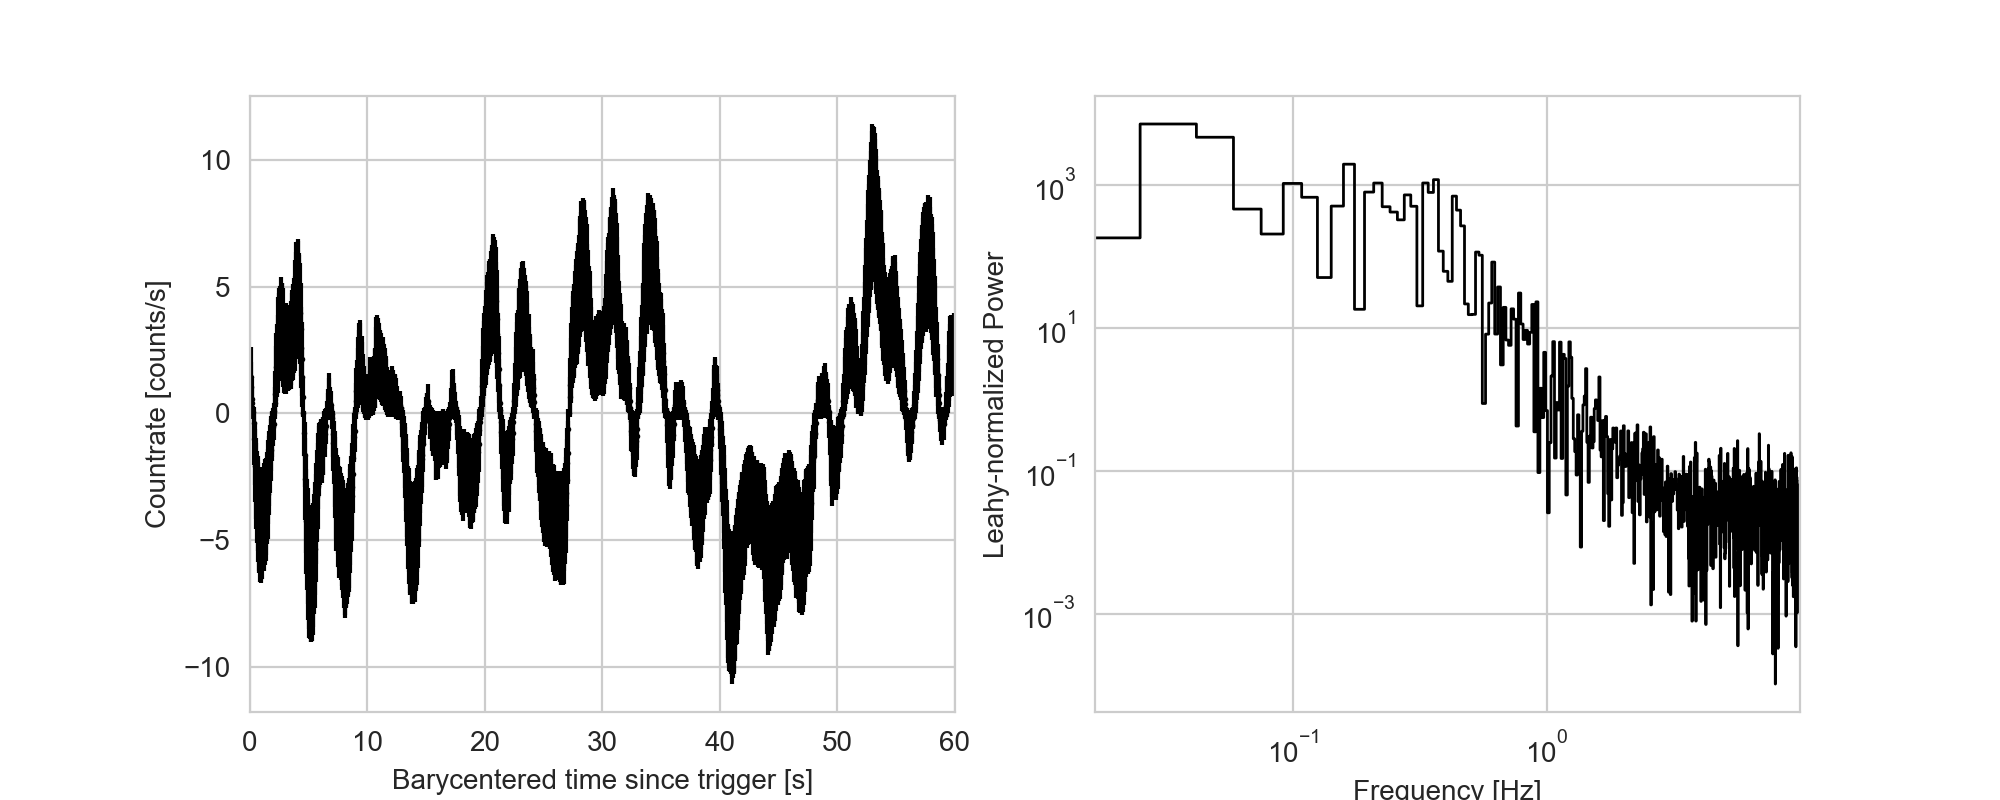

<IPython.core.display.Javascript object>


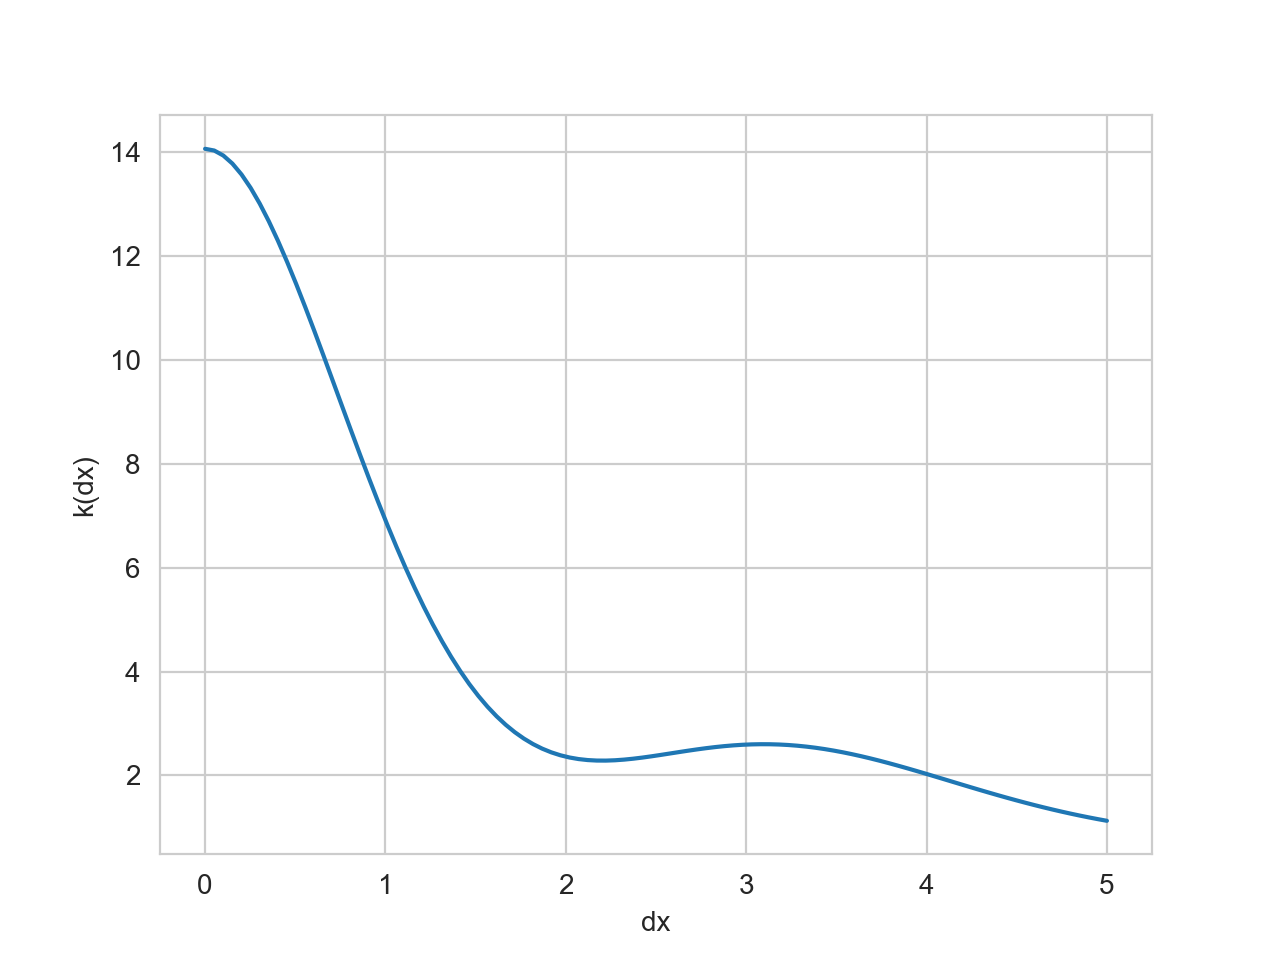

In [3]:
dt = 0.05
tseg = 60.0

time = np.linspace(0, 60, int(60/0.05))

alpha = [1.5, 4.5, 2.0]
beta = [10.5, 8.0]
sigma = 4.0

mean_val = 100.0

#kernel_params_true = {"alpha": alpha,
#                      "beta": beta,
#                      "acarma": sigma}

kernel_params_true = np.hstack([alpha, beta, sigma])

kernel = CARMA.init(alpha=alpha, beta=beta)
gp = GaussianProcess(kernel, time, diag=0.01)

key = random.PRNGKey(1200)
sample = gp.sample(key)# + mean_val
#sample = np.random.poisson(sample)
print(sample)
gp.condition(sample)
print(gp.log_probability(sample))

lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="frac")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

### Nested Sampling in Numpyro

In [6]:
def model(t, y=None):

    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-1, 2.5))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-1, 2.5))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-1, 2.5))
    
    log_beta1 = numpyro.sample("log_beta1", dist.Uniform(-1, 2.5))
    log_beta2 = numpyro.sample("log_beta2", dist.Uniform(-1, 2.5))
    
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(0, 5.3))
    
    log_mean = numpyro.sample("log_mean", dist.Uniform(0, 5.3))
    
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
                        beta=[jnp.exp(log_beta1), jnp.exp(log_beta2)], sigma=jnp.exp(log_sigma))
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=jnp.ones_like(t) * jnp.exp(log_mean))
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [7]:
npoints = 200
ns = NestedSampler(model)
ns.run(random.PRNGKey(200), lcsample.time[:npoints], y=lcsample.counts[:npoints])

In [8]:
ns.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 348908
# samples: 2800
# slices: 55125.0
# slices / acceptance: 21.0
# likelihood evals / sample: 124.6
# likelihood evals / slice: 5.5
--------
logZ=-650.93 +- 0.21
H=650.0
ESS=542
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 0.78 +- 0.87 | -0.5 / 1.11 / 1.87 | 1.02 | 1.02
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 1.92 +- 0.55 | 1.0 / 2.06 / 2.45 | 2.46 | 2.46
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 2.48 +- 0.022 | 2.453 / 2.487 / 2.498 | 2.5 | 2.5
--------
log_beta1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta1: -0.4 +- 0.56 | -0.93 / -0.64 / 0.44 | -0.73 | -0.73
--------
log_beta2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta2: 2.25 +- 0.12 | 2.1 / 2.25 / 

pred[139]: -19.0 +- 24.0 | -59.0 / -10.0 / -3.0 | -9.0 | -9.0
pred[140]: -19.0 +- 24.0 | -59.0 / -10.0 / -4.0 | -9.0 | -9.0
pred[141]: -19.0 +- 24.0 | -60.0 / -10.0 / -4.0 | -10.0 | -10.0
pred[142]: -20.0 +- 24.0 | -60.0 / -11.0 / -5.0 | -10.0 | -10.0
pred[143]: -20.0 +- 24.0 | -61.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[144]: -21.0 +- 24.0 | -61.0 / -12.0 / -6.0 | -11.0 | -11.0
pred[145]: -21.0 +- 24.0 | -62.0 / -12.0 / -6.0 | -12.0 | -12.0
pred[146]: -22.0 +- 24.0 | -62.0 / -13.0 / -7.0 | -12.0 | -12.0
pred[147]: -22.0 +- 24.0 | -63.0 / -13.0 / -7.0 | -13.0 | -13.0
pred[148]: -22.0 +- 24.0 | -63.0 / -13.0 / -7.0 | -13.0 | -13.0
pred[149]: -22.0 +- 24.0 | -63.0 / -13.0 / -7.0 | -13.0 | -13.0
pred[150]: -23.0 +- 24.0 | -63.0 / -14.0 / -8.0 | -13.0 | -13.0
pred[151]: -23.0 +- 24.0 | -63.0 / -13.0 / -7.0 | -13.0 | -13.0
pred[152]: -23.0 +- 24.0 | -64.0 / -14.0 / -8.0 | -14.0 | -14.0
pred[153]: -23.0 +- 24.0 | -63.0 / -13.0 / -7.0 | -13.0 | -13.0
pred[154]: -23.0 +- 24.0 | -64.0 / -14.0 / -

In [9]:
ns.print_summary()
samples, weights = ns.get_weighted_samples()
#samples = ns.get_samples(random.PRNGKey(3), num_samples=5000)


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 348908
# samples: 2800
# slices: 55125.0
# slices / acceptance: 21.0
# likelihood evals / sample: 124.6
# likelihood evals / slice: 5.5
--------
logZ=-650.93 +- 0.21
H=650.0
ESS=542
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 0.78 +- 0.87 | -0.5 / 1.11 / 1.87 | 1.02 | 1.02
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 1.92 +- 0.55 | 1.0 / 2.06 / 2.45 | 2.46 | 2.46
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 2.48 +- 0.022 | 2.453 / 2.487 / 2.498 | 2.5 | 2.5
--------
log_beta1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta1: -0.4 +- 0.56 | -0.93 / -0.64 / 0.44 | -0.73 | -0.73
--------
log_beta2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta2: 2.25 +- 0.12 | 2.1 / 2.25 / 

pred[117]: -21.0 +- 24.0 | -61.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[118]: -20.0 +- 24.0 | -61.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[119]: -20.0 +- 24.0 | -61.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[120]: -20.0 +- 24.0 | -60.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[121]: -20.0 +- 24.0 | -60.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[122]: -20.0 +- 24.0 | -61.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[123]: -20.0 +- 24.0 | -60.0 / -11.0 / -5.0 | -11.0 | -11.0
pred[124]: -20.0 +- 24.0 | -60.0 / -11.0 / -5.0 | -10.0 | -10.0
pred[125]: -20.0 +- 24.0 | -60.0 / -11.0 / -5.0 | -10.0 | -10.0
pred[126]: -19.0 +- 24.0 | -60.0 / -10.0 / -4.0 | -10.0 | -10.0
pred[127]: -19.0 +- 24.0 | -60.0 / -10.0 / -4.0 | -10.0 | -10.0
pred[128]: -19.0 +- 24.0 | -60.0 / -10.0 / -4.0 | -10.0 | -10.0
pred[129]: -19.0 +- 24.0 | -60.0 / -10.0 / -4.0 | -10.0 | -10.0
pred[130]: -19.0 +- 24.0 | -59.0 / -10.0 / -3.0 | -9.0 | -9.0
pred[131]: -19.0 +- 24.0 | -59.0 / -9.0 / -3.0 | -9.0 | -9.0
pred[132]: -18.0 +- 24.0 | -59.0 / -9.0 / -3.

In [10]:
kernel_params_true = np.hstack([kernel_params_true, jnp.log(mean_val)])

<IPython.core.display.Javascript object>


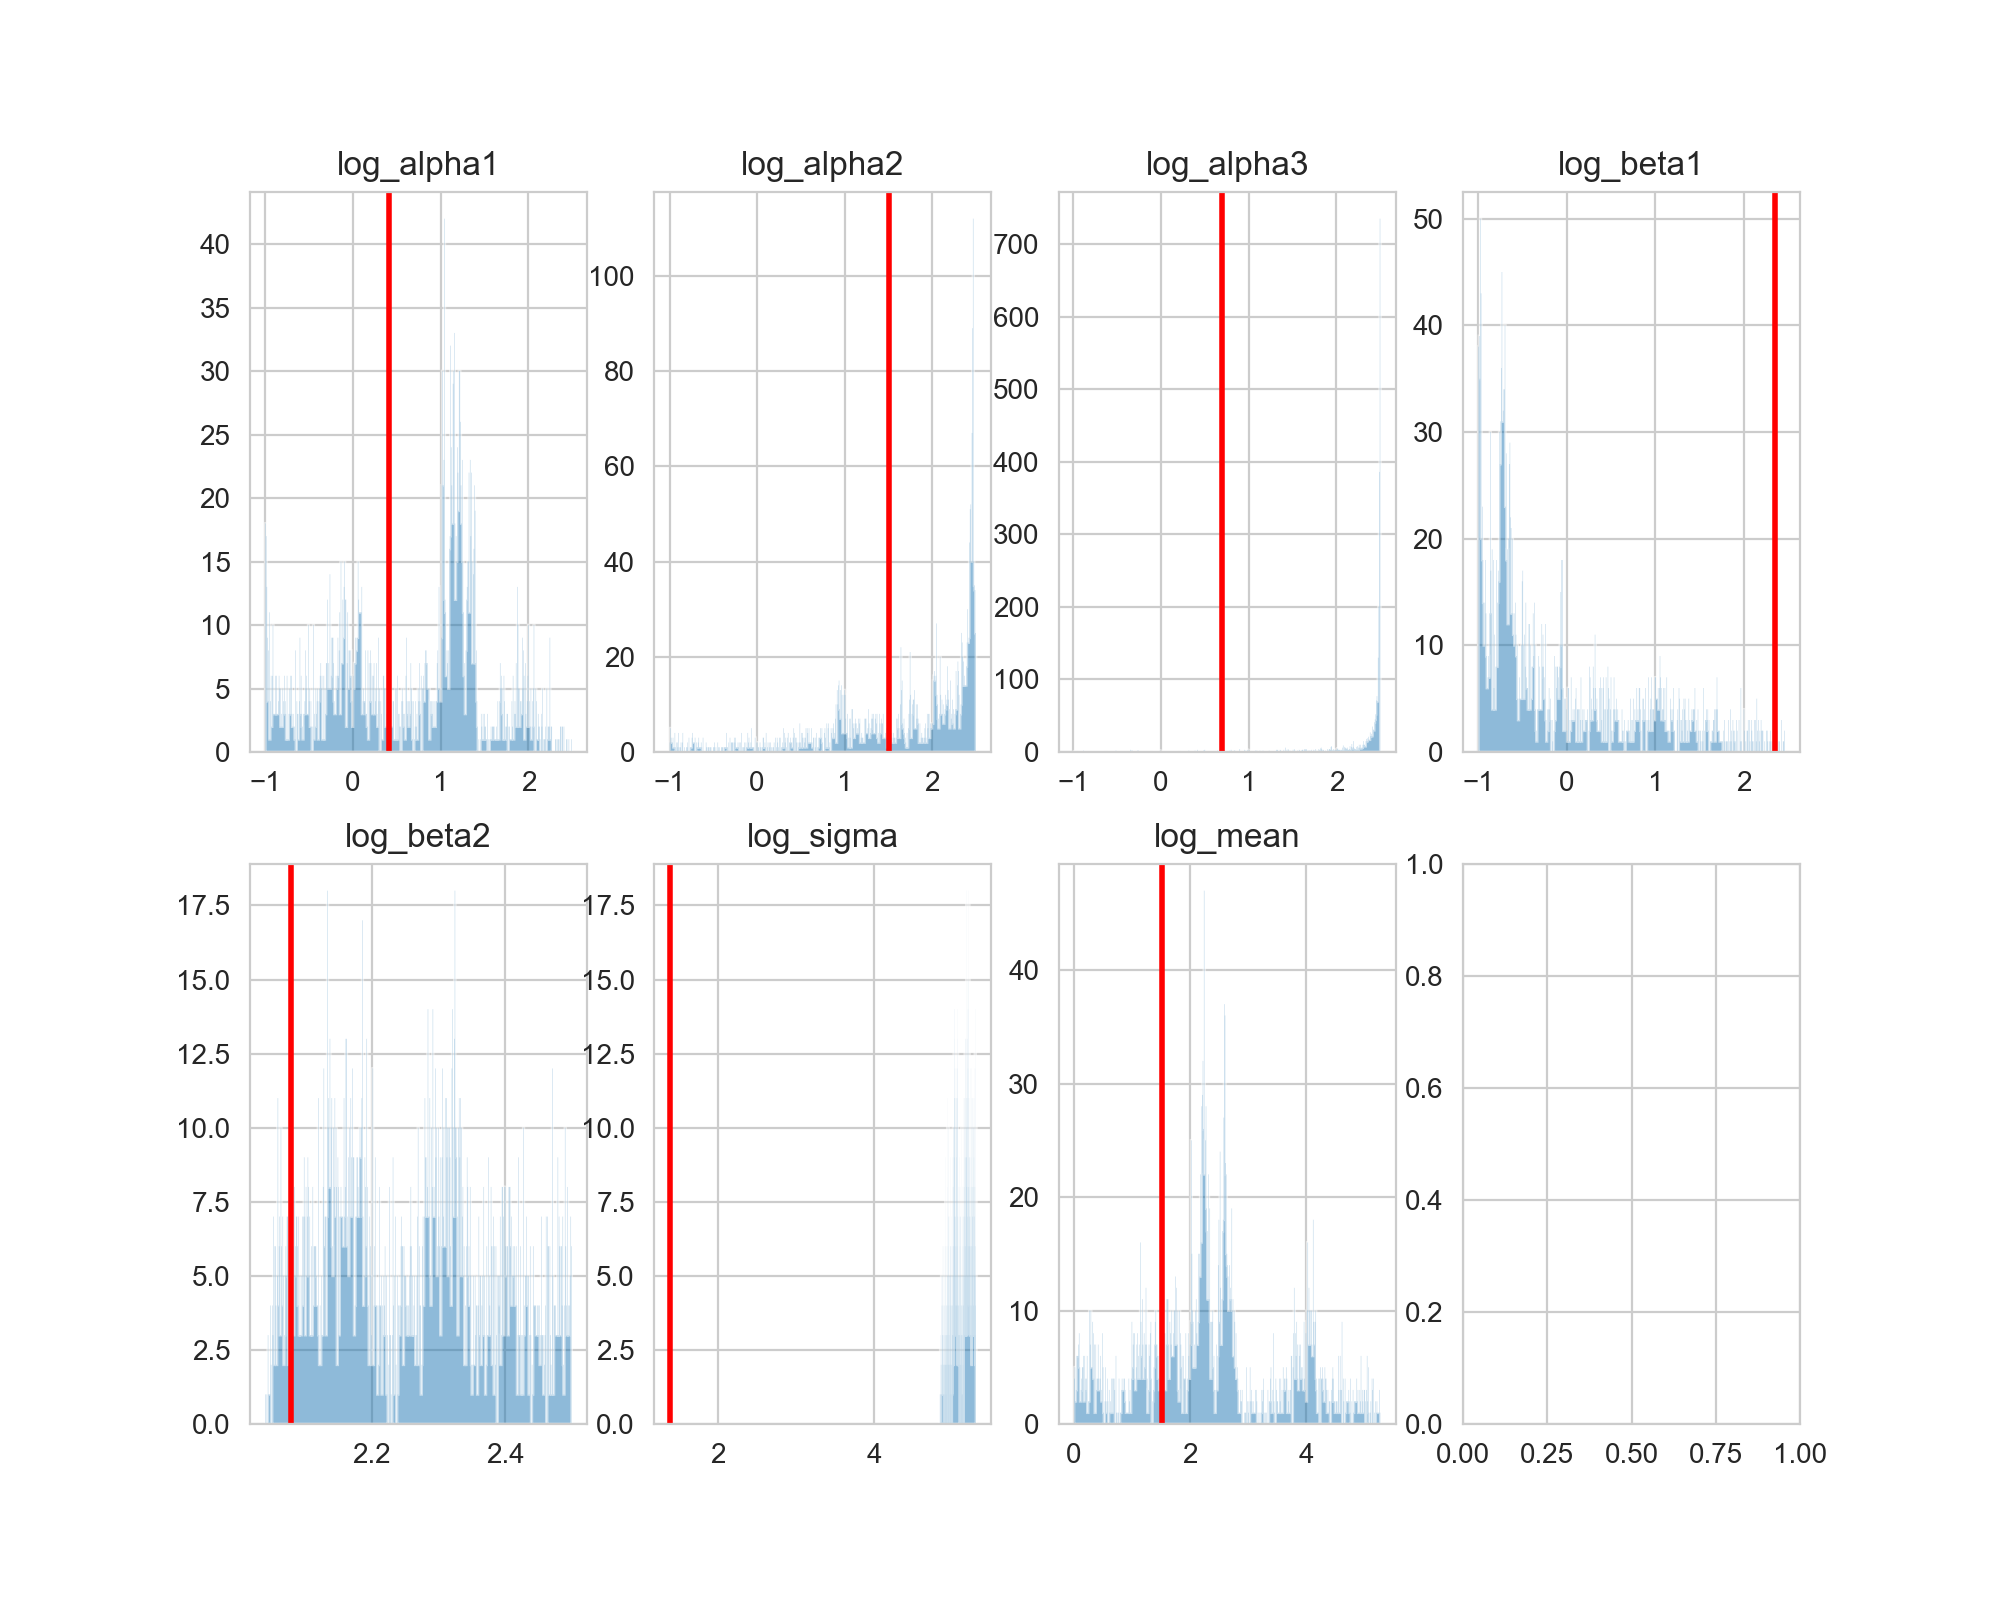

In [15]:
#samples = ns.get_samples(random.PRNGKey(3), num_samples=5000)

fig, axes = plt.subplots(2, 4, figsize=(10, 8))

kernel_var_names = ["log_alpha1", "log_alpha2", "log_alpha3",
                    "log_beta1", "log_beta2", "log_sigma", "log_mean"]

axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=500, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

<IPython.core.display.Javascript object>


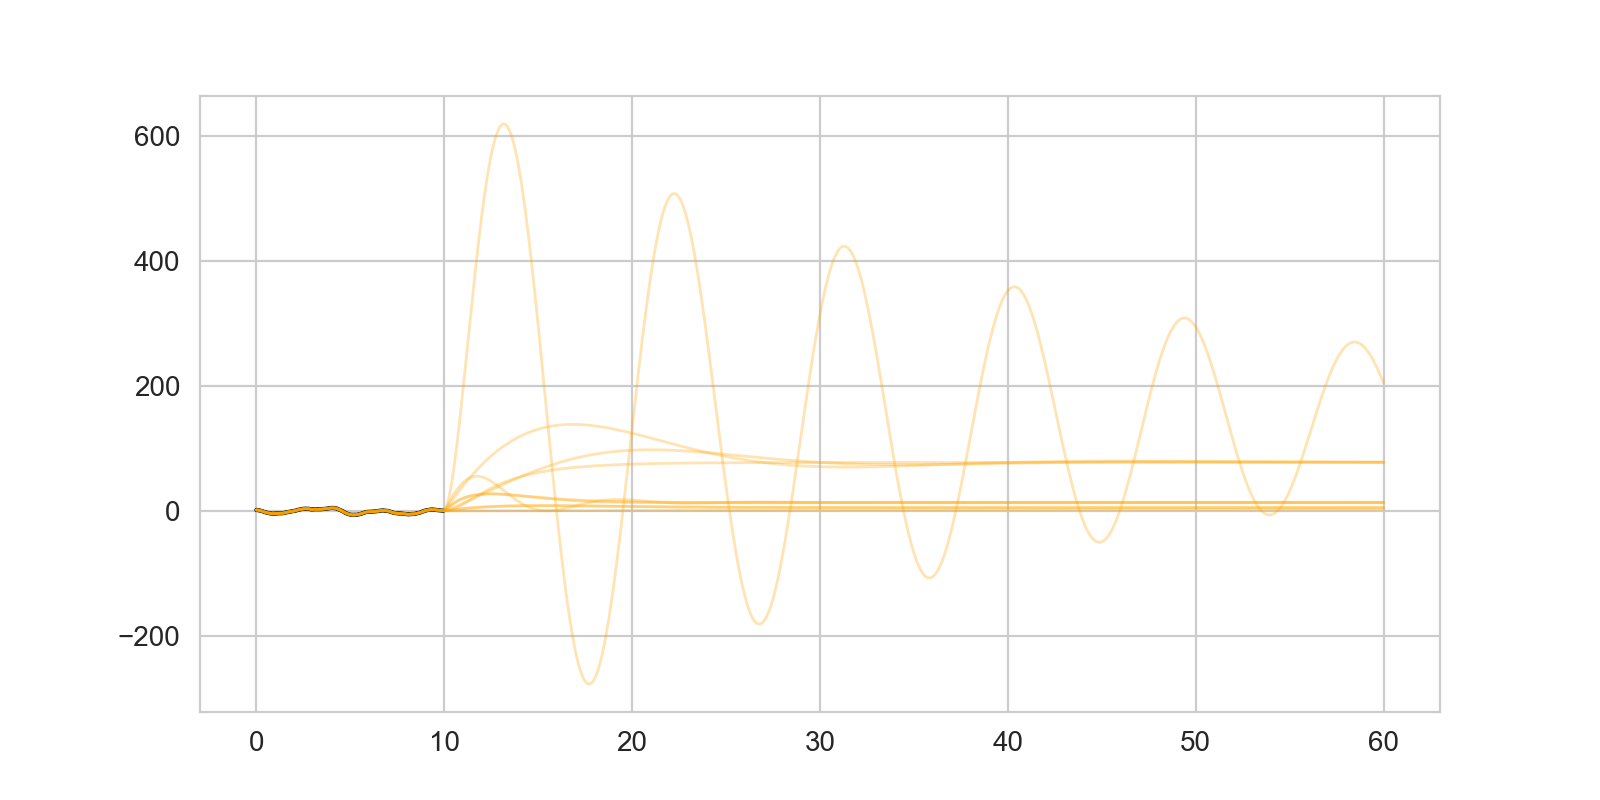

77.85629022627339
[Array(0.70810719, dtype=float64), Array(2.52820662, dtype=float64), Array(10.88455278, dtype=float64)]
140.85055934831271
[Array(0.68261682, dtype=float64), Array(0.56391463, dtype=float64), Array(1.47267068, dtype=float64)]
13.66061807571332
[Array(8.6387435, dtype=float64), Array(7.28542285, dtype=float64), Array(11.54835073, dtype=float64)]
78.4128307047679
[Array(0.7680307, dtype=float64), Array(3.26646021, dtype=float64), Array(12.13098255, dtype=float64)]
13.077517372712189
[Array(3.4077431, dtype=float64), Array(10.78879362, dtype=float64), Array(12.03091263, dtype=float64)]
77.43878612629624
[Array(0.41531074, dtype=float64), Array(1.87772692, dtype=float64), Array(2.34789626, dtype=float64)]
5.377487773837753
[Array(1.10507889, dtype=float64), Array(5.94193273, dtype=float64), Array(12.11269755, dtype=float64)]
13.25779796523843
[Array(3.06506988, dtype=float64), Array(11.67310824, dtype=float64), Array(11.85551045, dtype=float64)]
2.9389877125394204
[Array(

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lcsample.time[:npoints], lcsample.counts[:npoints], color="black")

nsims = 10
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

tpost = np.linspace(0.0, time[-1], 2000)

for idx in idx_all:
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx]),
             jnp.exp(samples["log_alpha3"][idx])]
    
    beta_post = [jnp.exp(samples["log_beta1"][idx]),
                jnp.exp(samples["log_beta2"][idx])]
    sigma_post = jnp.exp(samples["log_sigma"][idx])
    mean_post = jnp.exp(samples["log_mean"][idx])
    print(mean_post)
    
    print(alpha_post)
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post, 
                        sigma=sigma_post)
    
    gp = GaussianProcess(kernel_post, lcsample.time[:npoints], diag=0.01,
                         mean_value=jnp.ones_like(lcsample.time[:npoints])*mean_post)

    _, cond = gp.condition(lcsample.counts[:npoints], tpost, include_mean=True)

    ax.plot(tpost, cond.loc+mean_post, lw=1, color="orange", alpha=0.3)


## With a Mean Model

Let's add a mean model:

In [16]:
def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]
    logconst = params[4]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y + jnp.exp(logconst)

INFO[2023-10-07 18:40:15,833]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-07 18:40:15,834]: Checking if light curve is sorted.
INFO[2023-10-07 18:40:15,835]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-6796651.00738979


<IPython.core.display.Javascript object>


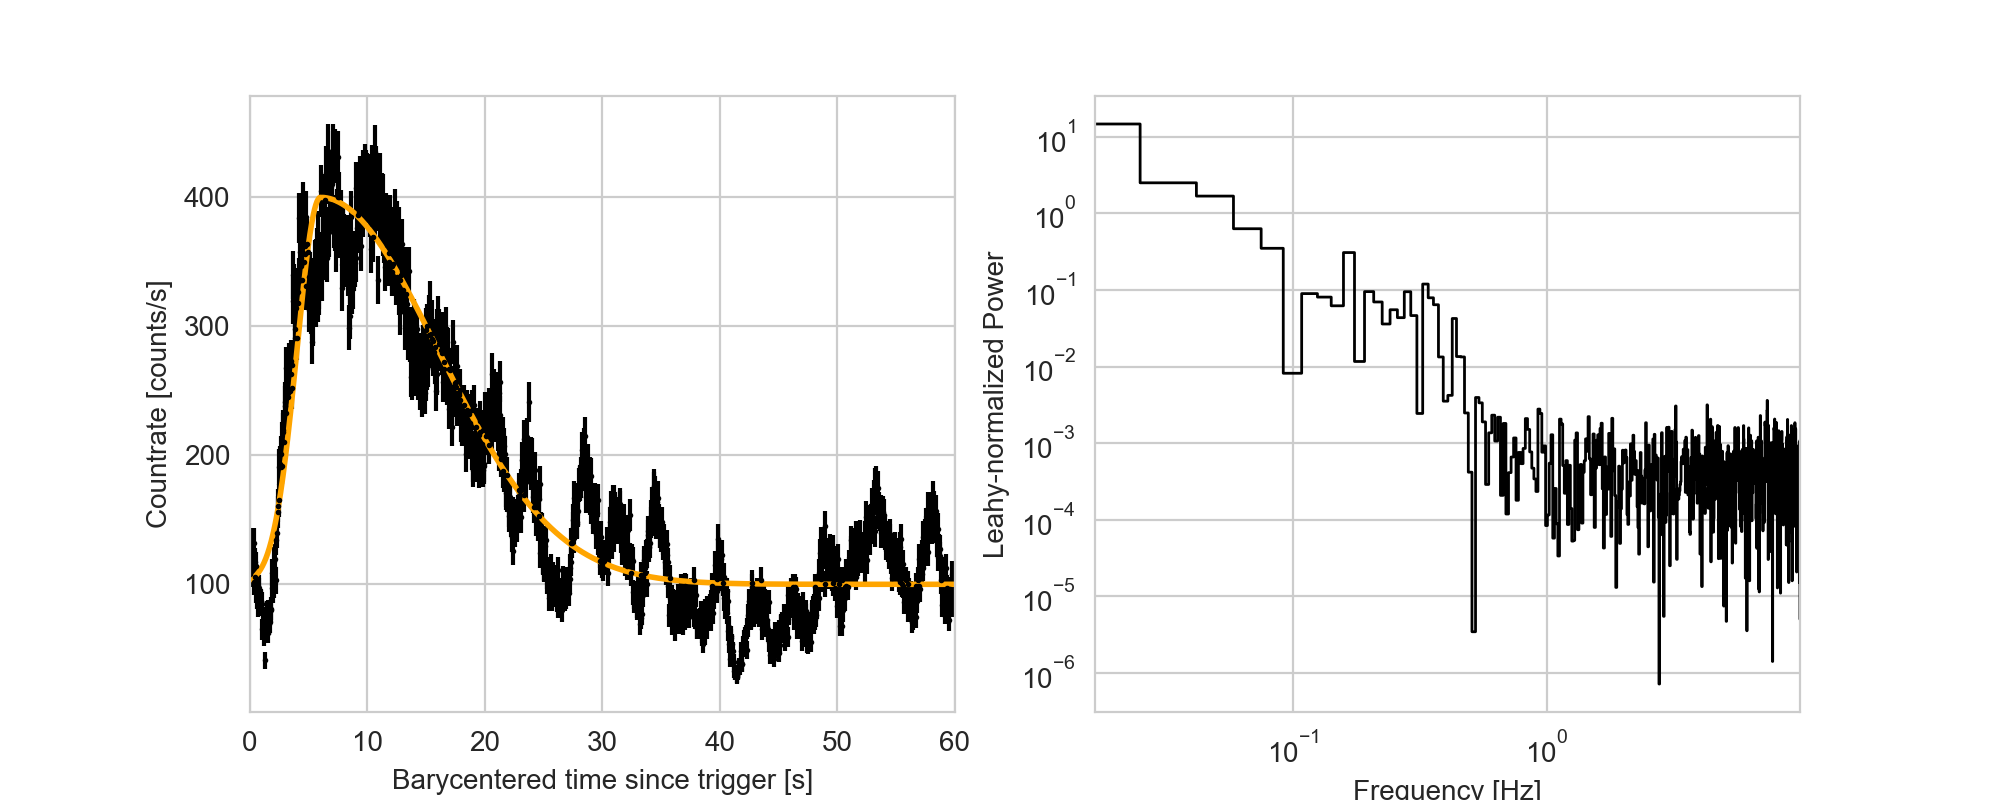

<IPython.core.display.Javascript object>


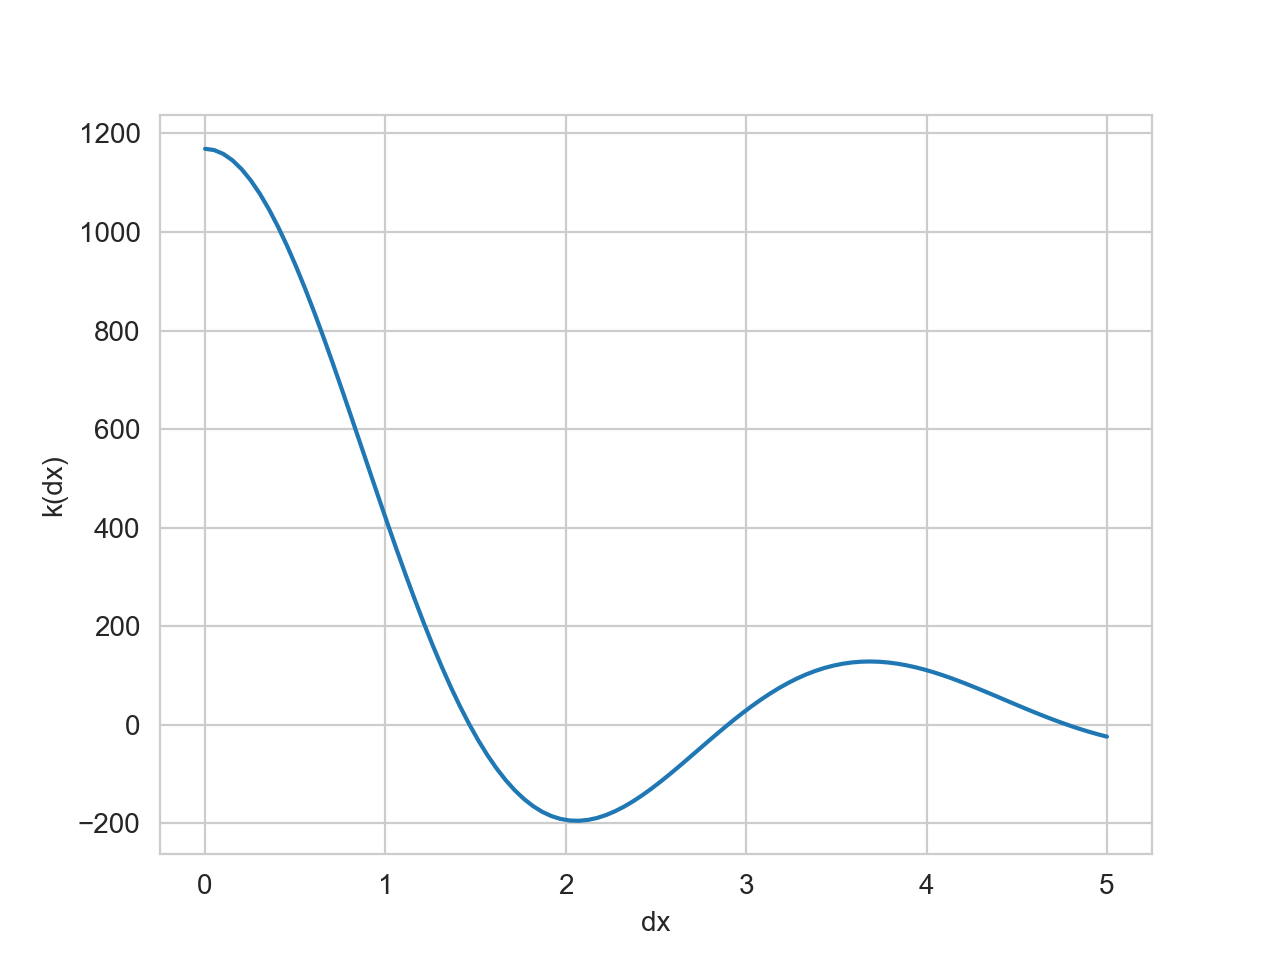

In [190]:
# Make a time array
dt = 0.05
tseg = 60.0

time = np.linspace(0, 60, int(60/0.05))

alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 100

skew_amp = 300
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0
const = 100.0


mean_params_true = [np.log(skew_amp),
               skew_t0,
               np.log(skew_sig1),
               np.log(skew_sig2),
               np.log(const)]


mean_val = skewgaussian(time, mean_params_true)

#kernel_params_true = {"alpha": alpha,
#                      "beta": beta,
#                      "acarma": sigma}

kernel_params_true = np.hstack([alpha, beta, sigma])

kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, time, diag=0.01)

key = random.PRNGKey(1200)
sample = gp.sample(key) + mean_val
sample = np.random.poisson(sample)

gp.condition(sample)
print(gp.log_probability(sample))

lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="frac")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.plot(time, mean_val, lw=2, color="orange")

ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")


def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

In [179]:
mean_params_true

[Array(5.70378247, dtype=float64, weak_type=True),
 6.0,
 Array(0.69314718, dtype=float64, weak_type=True),
 Array(2.30258509, dtype=float64, weak_type=True),
 Array(4.60517019, dtype=float64, weak_type=True)]

In [183]:
def model_with_mean(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(2, 7))
    t0 = numpyro.sample("t0", dist.Uniform(2, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3))
    log_const = numpyro.sample("log_const", dist.Uniform(3, 6))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-1, 2.5))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-1, 2.5))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-1, 2.5))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-1, 2.5))
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(0, 5.3))
    
    
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
                        beta=[jnp.exp(log_beta)], sigma=jnp.exp(log_sigma))
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [184]:
npoints = len(lcsample.time)
ns = NestedSampler(model_with_mean)
ns.run(random.PRNGKey(2), lcsample.time[:npoints], y=lcsample.counts[:npoints])

In [185]:
samples, weights = ns.get_weighted_samples()

ns.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 688539
# samples: 6750
# slices: 172500.0
# slices / acceptance: 30.0
# likelihood evals / sample: 102.0
# likelihood evals / slice: 3.9
--------
logZ=-4895.9 +- 0.25
H=4900.0
ESS=1268
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 0.54 +- 0.7 | -0.42 / 0.56 / 1.4 | 1.19 | 1.19
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 1.65 +- 0.13 | 1.51 / 1.63 / 1.82 | 1.67 | 1.67
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 0.24 +- 0.43 | -0.28 / 0.2 / 0.75 | 0.54 | 0.54
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 5.65 +- 0.1 | 5.52 / 5.65 / 5.75 | 5.65 | 5.65
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 1.2 +- 0.76 | 0.18 / 1.23 / 2.2 | 2.0 

pred[138]: 38.0 +- 26.0 | 9.0 / 36.0 / 70.0 | 32.0 | 32.0
pred[139]: 38.0 +- 26.0 | 10.0 / 36.0 / 71.0 | 33.0 | 33.0
pred[140]: 39.0 +- 26.0 | 9.0 / 36.0 / 71.0 | 33.0 | 33.0
pred[141]: 38.0 +- 26.0 | 9.0 / 36.0 / 71.0 | 33.0 | 33.0
pred[142]: 38.0 +- 26.0 | 9.0 / 36.0 / 71.0 | 32.0 | 32.0
pred[143]: 37.0 +- 26.0 | 8.0 / 35.0 / 70.0 | 32.0 | 32.0
pred[144]: 36.0 +- 26.0 | 7.0 / 33.0 / 68.0 | 30.0 | 30.0
pred[145]: 34.0 +- 26.0 | 5.0 / 32.0 / 67.0 | 29.0 | 29.0
pred[146]: 33.0 +- 26.0 | 4.0 / 30.0 / 65.0 | 27.0 | 27.0
pred[147]: 30.0 +- 26.0 | 1.0 / 28.0 / 63.0 | 25.0 | 25.0
pred[148]: 28.0 +- 26.0 | -1.0 / 26.0 / 61.0 | 23.0 | 23.0
pred[149]: 26.0 +- 26.0 | -3.0 / 23.0 / 58.0 | 20.0 | 20.0
pred[150]: 23.0 +- 26.0 | -6.0 / 21.0 / 55.0 | 18.0 | 18.0
pred[151]: 20.0 +- 26.0 | -9.0 / 18.0 / 52.0 | 15.0 | 15.0
pred[152]: 17.0 +- 26.0 | -12.0 / 15.0 / 49.0 | 12.0 | 12.0
pred[153]: 14.0 +- 26.0 | -14.0 / 12.0 / 46.0 | 9.0 | 9.0
pred[154]: 11.0 +- 26.0 | -17.0 / 9.0 / 43.0 | 6.0 | 6.0
pred[155

pred[311]: 20.0 +- 21.0 | -3.0 / 19.0 / 44.0 | 17.0 | 17.0
pred[312]: 20.0 +- 21.0 | -2.0 / 19.0 / 45.0 | 18.0 | 18.0
pred[313]: 21.0 +- 21.0 | -2.0 / 19.0 / 45.0 | 18.0 | 18.0
pred[314]: 20.0 +- 21.0 | -2.0 / 19.0 / 44.0 | 18.0 | 18.0
pred[315]: 20.0 +- 21.0 | -2.0 / 19.0 / 44.0 | 17.0 | 17.0
pred[316]: 19.0 +- 21.0 | -3.0 / 18.0 / 44.0 | 17.0 | 17.0
pred[317]: 19.0 +- 21.0 | -4.0 / 17.0 / 43.0 | 16.0 | 16.0
pred[318]: 18.0 +- 21.0 | -5.0 / 17.0 / 42.0 | 15.0 | 15.0
pred[319]: 17.0 +- 21.0 | -6.0 / 15.0 / 41.0 | 14.0 | 14.0
pred[320]: 16.0 +- 21.0 | -7.0 / 14.0 / 40.0 | 13.0 | 13.0
pred[321]: 14.0 +- 21.0 | -9.0 / 13.0 / 39.0 | 12.0 | 12.0
pred[322]: 13.0 +- 21.0 | -10.0 / 12.0 / 38.0 | 11.0 | 11.0
pred[323]: 12.0 +- 21.0 | -11.0 / 11.0 / 37.0 | 9.0 | 9.0
pred[324]: 10.0 +- 21.0 | -13.0 / 9.0 / 35.0 | 8.0 | 8.0
pred[325]: 9.0 +- 21.0 | -14.0 / 8.0 / 34.0 | 7.0 | 7.0
pred[326]: 8.0 +- 21.0 | -16.0 / 7.0 / 33.0 | 5.0 | 5.0
pred[327]: 7.0 +- 21.0 | -17.0 / 5.0 / 32.0 | 4.0 | 4.0
pred[328

pred[450]: -34.0 +- 22.0 | -61.0 / -34.0 / -8.0 | -34.0 | -34.0
pred[451]: -32.0 +- 22.0 | -59.0 / -32.0 / -7.0 | -33.0 | -33.0
pred[452]: -31.0 +- 22.0 | -58.0 / -31.0 / -5.0 | -31.0 | -31.0
pred[453]: -29.0 +- 22.0 | -56.0 / -29.0 / -3.0 | -29.0 | -29.0
pred[454]: -26.0 +- 22.0 | -53.0 / -26.0 / -0.0 | -26.0 | -26.0
pred[455]: -24.0 +- 22.0 | -50.0 / -24.0 / 2.0 | -24.0 | -24.0
pred[456]: -21.0 +- 22.0 | -47.0 / -21.0 / 5.0 | -21.0 | -21.0
pred[457]: -17.0 +- 22.0 | -44.0 / -17.0 / 8.0 | -18.0 | -18.0
pred[458]: -14.0 +- 22.0 | -41.0 / -14.0 / 11.0 | -14.0 | -14.0
pred[459]: -11.0 +- 22.0 | -37.0 / -10.0 / 15.0 | -11.0 | -11.0
pred[460]: -7.0 +- 22.0 | -34.0 / -7.0 / 18.0 | -7.0 | -7.0
pred[461]: -3.0 +- 22.0 | -30.0 / -3.0 / 22.0 | -3.0 | -3.0
pred[462]: 0.0 +- 22.0 | -27.0 / 1.0 / 26.0 | 0.0 | 0.0
pred[463]: 4.0 +- 22.0 | -23.0 / 4.0 / 29.0 | 4.0 | 4.0
pred[464]: 8.0 +- 22.0 | -19.0 / 8.0 / 33.0 | 7.0 | 7.0
pred[465]: 11.0 +- 22.0 | -16.0 / 11.0 / 36.0 | 11.0 | 11.0
pred[466]: 14.0

pred[595]: 2.0 +- 17.0 | -19.0 / 3.0 / 20.0 | 3.0 | 3.0
pred[596]: 0.0 +- 17.0 | -20.0 / 2.0 / 18.0 | 1.0 | 1.0
pred[597]: -1.0 +- 17.0 | -22.0 / 0.0 / 16.0 | -1.0 | -1.0
pred[598]: -2.0 +- 17.0 | -23.0 / -1.0 / 15.0 | -2.0 | -2.0
pred[599]: -3.0 +- 17.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[600]: -4.0 +- 17.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[601]: -4.0 +- 17.0 | -24.0 / -3.0 / 14.0 | -4.0 | -4.0
pred[602]: -4.0 +- 16.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[603]: -3.0 +- 16.0 | -24.0 / -2.0 / 14.0 | -3.0 | -3.0
pred[604]: -2.0 +- 16.0 | -23.0 / -1.0 / 15.0 | -2.0 | -2.0
pred[605]: -1.0 +- 16.0 | -21.0 / 0.0 / 16.0 | -1.0 | -1.0
pred[606]: 1.0 +- 16.0 | -20.0 / 2.0 / 18.0 | 1.0 | 1.0
pred[607]: 3.0 +- 16.0 | -18.0 / 4.0 / 20.0 | 3.0 | 3.0
pred[608]: 5.0 +- 16.0 | -16.0 / 6.0 / 22.0 | 5.0 | 5.0
pred[609]: 7.0 +- 16.0 | -14.0 / 8.0 / 24.0 | 7.0 | 7.0
pred[610]: 9.0 +- 16.0 | -11.0 / 11.0 / 26.0 | 10.0 | 10.0
pred[611]: 12.0 +- 16.0 | -9.0 / 13.0 / 29.0 | 12.0 | 12.0
pred[612

pred[742]: -10.0 +- 14.0 | -26.0 / -10.0 / 7.0 | -12.0 | -12.0
pred[743]: -9.0 +- 14.0 | -25.0 / -9.0 / 7.0 | -11.0 | -11.0
pred[744]: -8.0 +- 14.0 | -25.0 / -9.0 / 8.0 | -10.0 | -10.0
pred[745]: -8.0 +- 14.0 | -24.0 / -8.0 / 8.0 | -10.0 | -10.0
pred[746]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -9.0 | -9.0
pred[747]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -9.0 | -9.0
pred[748]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -9.0 | -9.0
pred[749]: -8.0 +- 14.0 | -24.0 / -8.0 / 9.0 | -10.0 | -10.0
pred[750]: -8.0 +- 14.0 | -25.0 / -8.0 / 8.0 | -10.0 | -10.0
pred[751]: -9.0 +- 14.0 | -25.0 / -9.0 / 8.0 | -10.0 | -10.0
pred[752]: -9.0 +- 14.0 | -26.0 / -9.0 / 7.0 | -11.0 | -11.0
pred[753]: -10.0 +- 14.0 | -27.0 / -10.0 / 7.0 | -12.0 | -12.0
pred[754]: -11.0 +- 14.0 | -27.0 / -11.0 / 6.0 | -13.0 | -13.0
pred[755]: -12.0 +- 14.0 | -28.0 / -12.0 / 5.0 | -14.0 | -14.0
pred[756]: -13.0 +- 14.0 | -29.0 / -13.0 / 4.0 | -15.0 | -15.0
pred[757]: -14.0 +- 14.0 | -31.0 / -15.0 / 2.0 | -16.0 | -16.0
pred[758]: -16.0 +

pred[897]: -39.0 +- 15.0 | -57.0 / -40.0 / -20.0 | -43.0 | -43.0
pred[898]: -39.0 +- 15.0 | -57.0 / -40.0 / -20.0 | -43.0 | -43.0
pred[899]: -38.0 +- 15.0 | -56.0 / -39.0 / -19.0 | -42.0 | -42.0
pred[900]: -37.0 +- 15.0 | -55.0 / -38.0 / -18.0 | -41.0 | -41.0
pred[901]: -36.0 +- 15.0 | -54.0 / -37.0 / -17.0 | -40.0 | -40.0
pred[902]: -35.0 +- 15.0 | -53.0 / -36.0 / -16.0 | -39.0 | -39.0
pred[903]: -34.0 +- 15.0 | -52.0 / -35.0 / -15.0 | -38.0 | -38.0
pred[904]: -33.0 +- 15.0 | -51.0 / -34.0 / -14.0 | -37.0 | -37.0
pred[905]: -32.0 +- 15.0 | -50.0 / -33.0 / -12.0 | -36.0 | -36.0
pred[906]: -31.0 +- 15.0 | -49.0 / -32.0 / -11.0 | -35.0 | -35.0
pred[907]: -29.0 +- 16.0 | -48.0 / -31.0 / -10.0 | -34.0 | -34.0
pred[908]: -28.0 +- 16.0 | -46.0 / -29.0 / -8.0 | -32.0 | -32.0
pred[909]: -27.0 +- 16.0 | -45.0 / -28.0 / -7.0 | -31.0 | -31.0
pred[910]: -25.0 +- 16.0 | -43.0 / -27.0 / -6.0 | -30.0 | -30.0
pred[911]: -24.0 +- 16.0 | -42.0 / -25.0 / -4.0 | -28.0 | -28.0
pred[912]: -23.0 +- 16.0 | -4

pred[1072]: 68.0 +- 17.0 | 50.0 / 67.0 / 88.0 | 63.0 | 63.0
pred[1073]: 66.0 +- 17.0 | 48.0 / 65.0 / 87.0 | 61.0 | 61.0
pred[1074]: 64.0 +- 17.0 | 46.0 / 63.0 / 85.0 | 59.0 | 59.0
pred[1075]: 62.0 +- 17.0 | 44.0 / 61.0 / 82.0 | 57.0 | 57.0
pred[1076]: 60.0 +- 17.0 | 41.0 / 58.0 / 80.0 | 55.0 | 55.0
pred[1077]: 57.0 +- 17.0 | 39.0 / 56.0 / 77.0 | 52.0 | 52.0
pred[1078]: 55.0 +- 17.0 | 36.0 / 53.0 / 75.0 | 49.0 | 49.0
pred[1079]: 52.0 +- 17.0 | 34.0 / 50.0 / 72.0 | 47.0 | 47.0
pred[1080]: 49.0 +- 17.0 | 31.0 / 48.0 / 69.0 | 44.0 | 44.0
pred[1081]: 46.0 +- 17.0 | 28.0 / 45.0 / 66.0 | 41.0 | 41.0
pred[1082]: 44.0 +- 17.0 | 25.0 / 42.0 / 64.0 | 38.0 | 38.0
pred[1083]: 41.0 +- 17.0 | 23.0 / 40.0 / 61.0 | 36.0 | 36.0
pred[1084]: 39.0 +- 17.0 | 20.0 / 37.0 / 59.0 | 33.0 | 33.0
pred[1085]: 36.0 +- 17.0 | 18.0 / 35.0 / 56.0 | 31.0 | 31.0
pred[1086]: 34.0 +- 17.0 | 16.0 / 33.0 / 54.0 | 29.0 | 29.0
pred[1087]: 32.0 +- 17.0 | 14.0 / 31.0 / 52.0 | 27.0 | 27.0
pred[1088]: 30.0 +- 17.0 | 12.0 / 29.0 /

In [191]:
print(mean_params_true)

[5.703782474656201, 6.0, 0.6931471805599453, 2.302585092994046, 4.605170185988092]


<IPython.core.display.Javascript object>


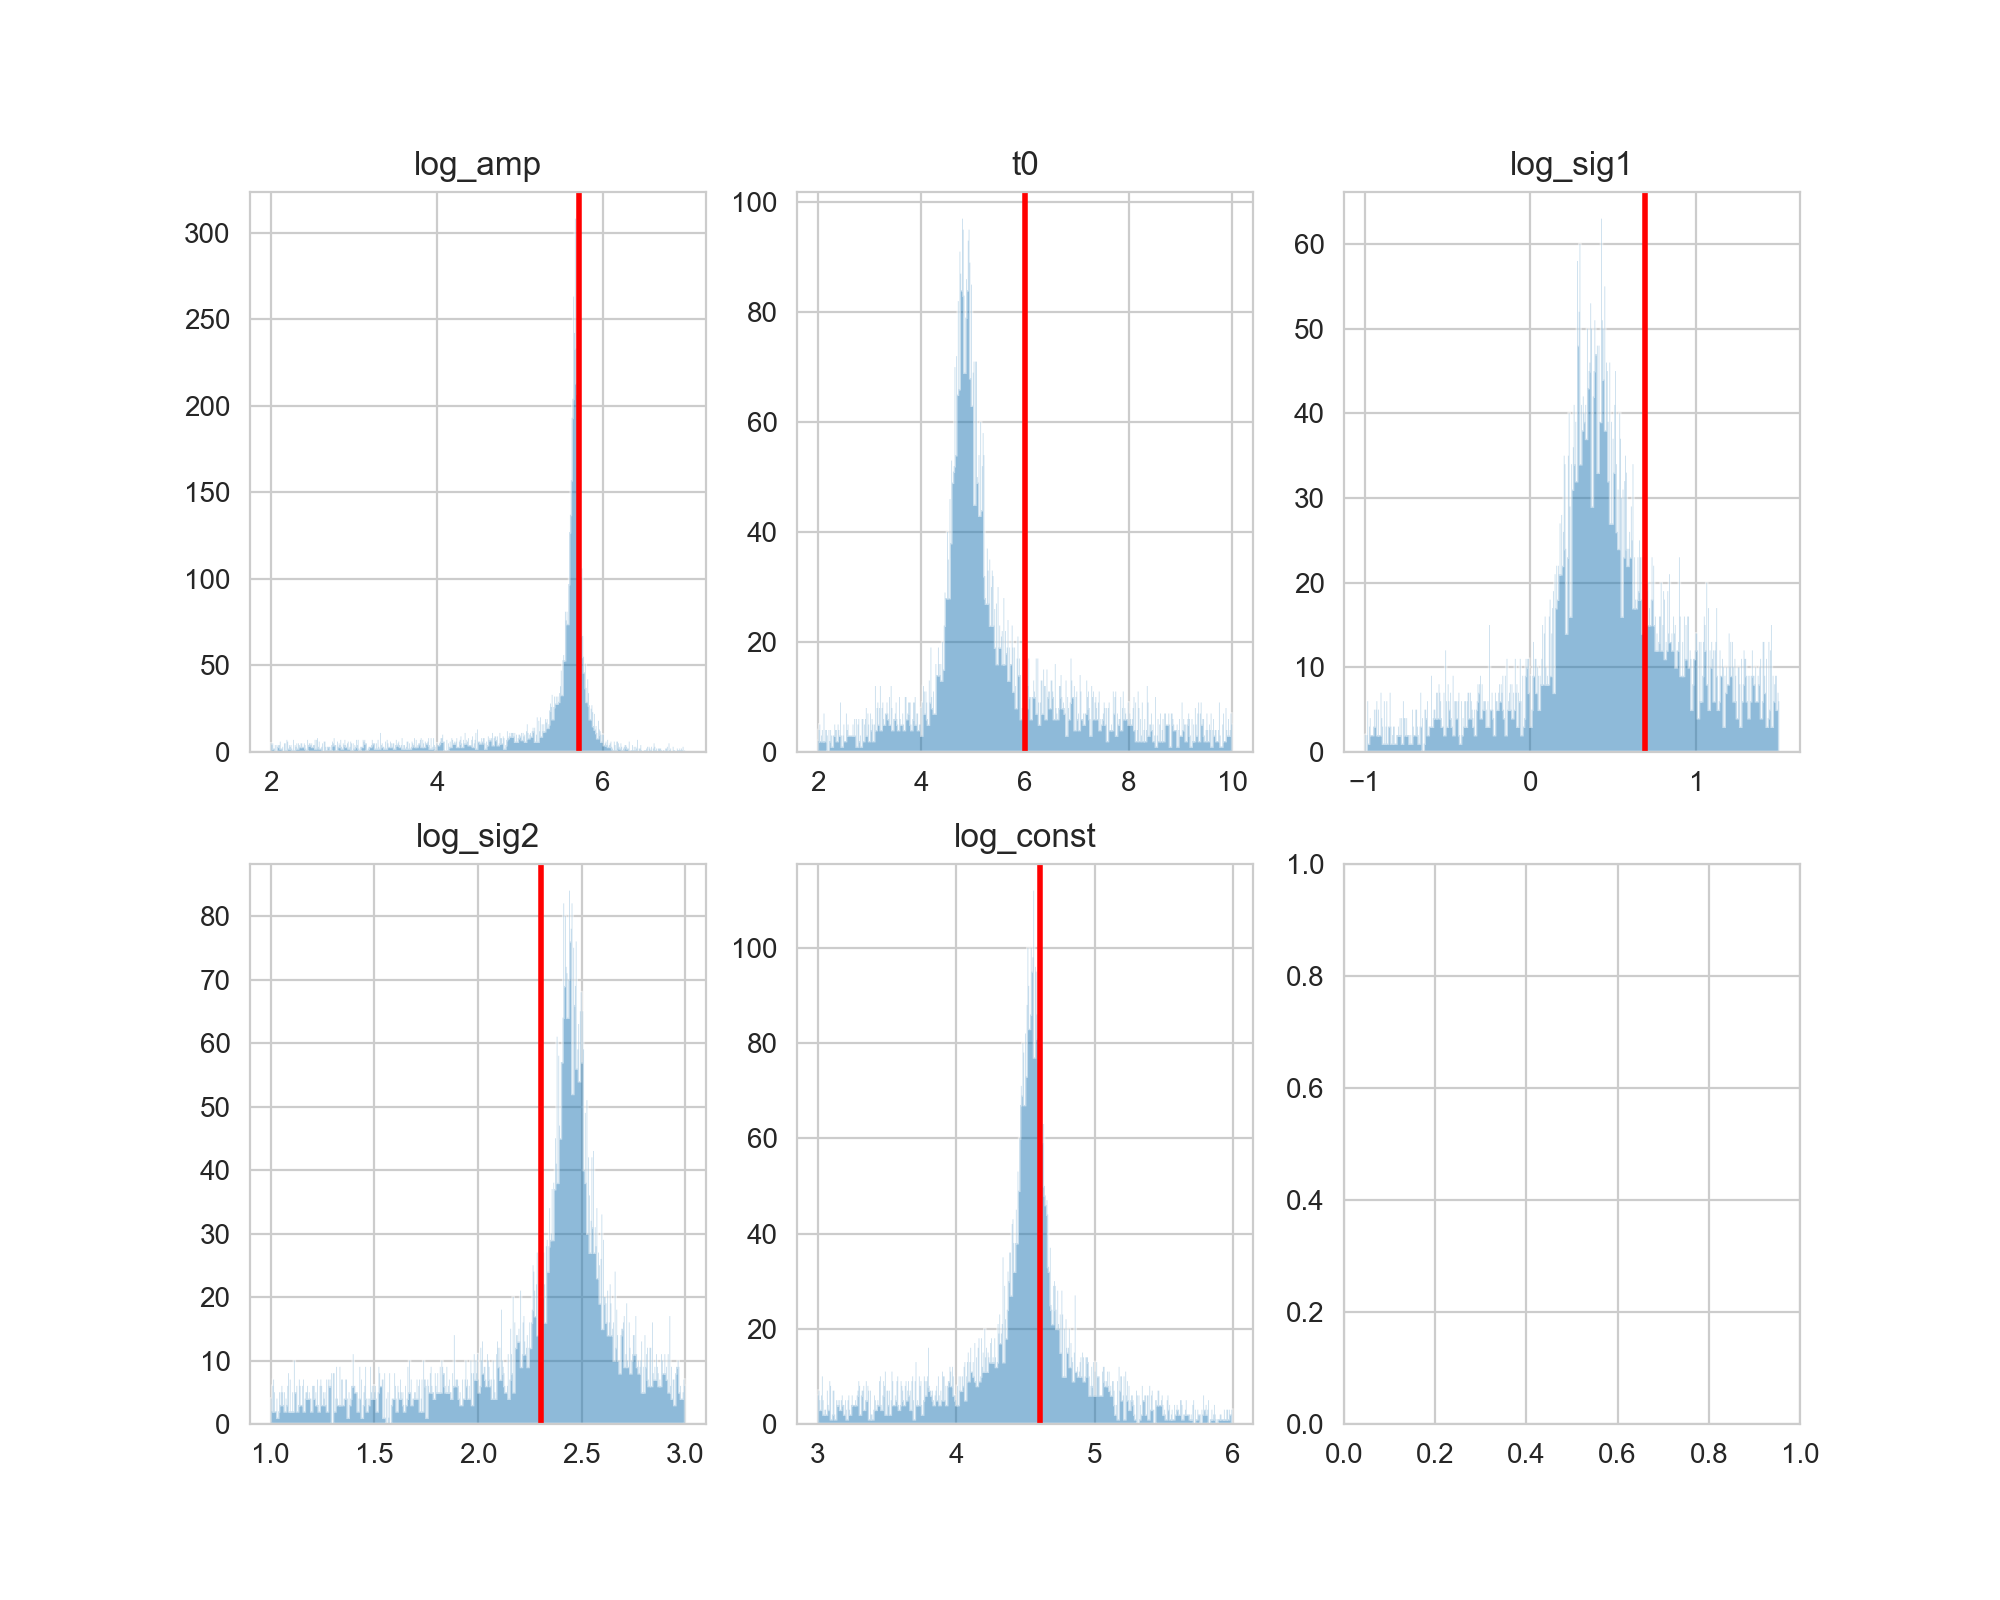

In [193]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=500, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


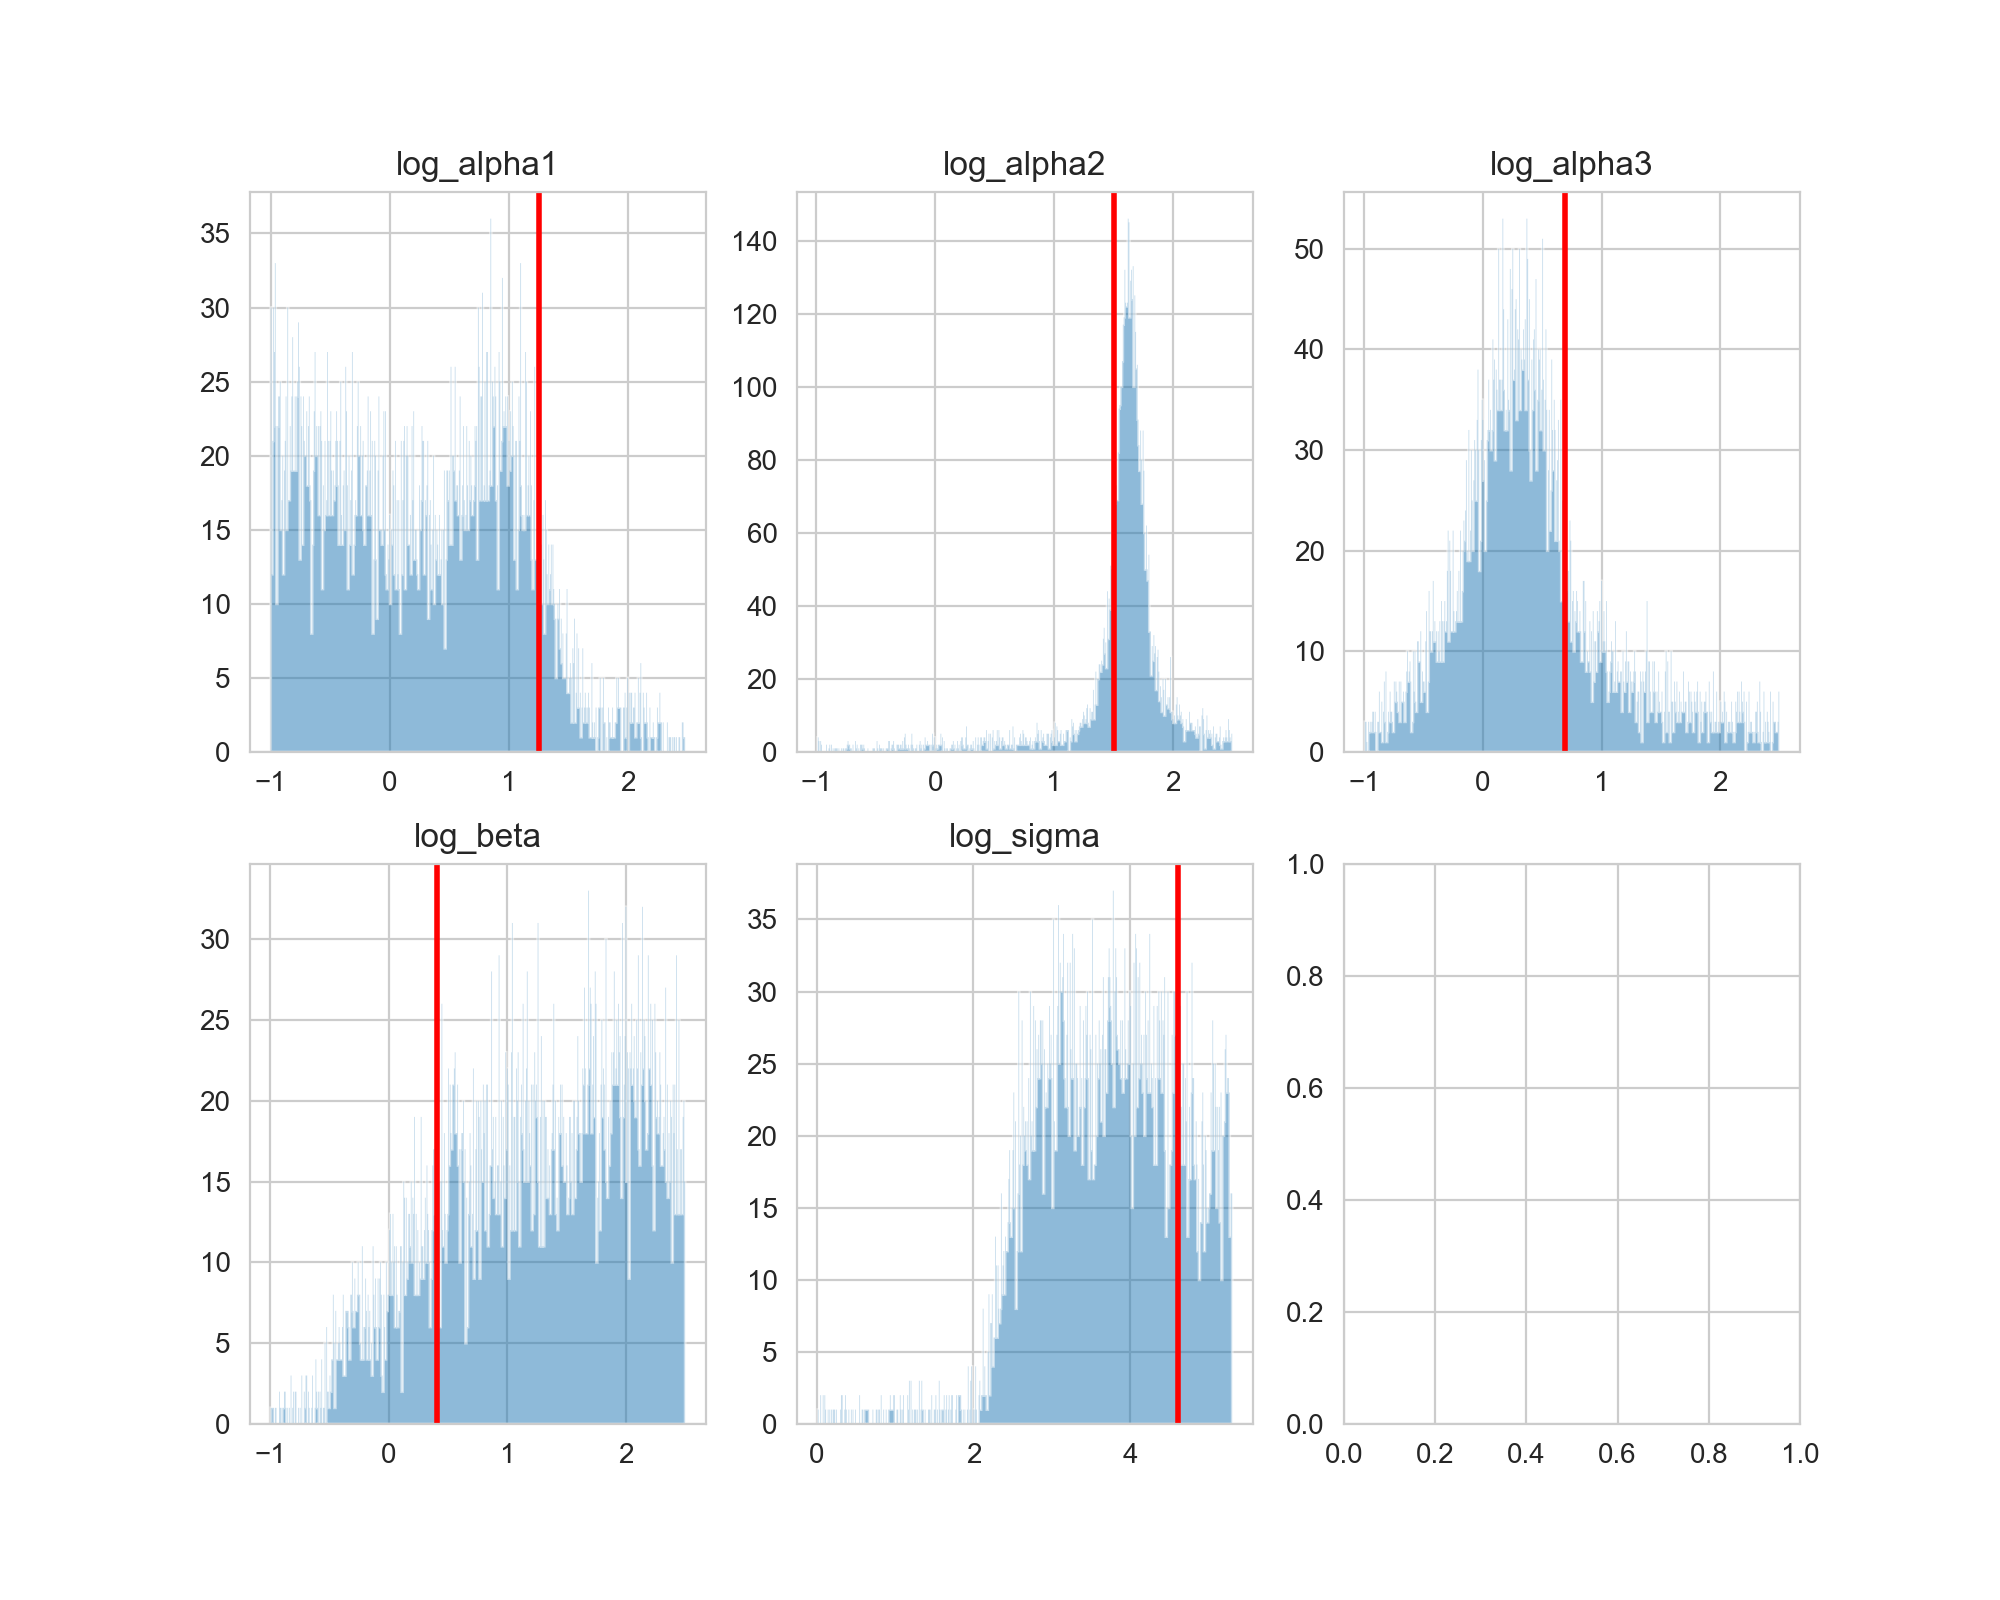

In [194]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_alpha3",
                    "log_beta", "log_sigma",]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=500, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [196]:
samples

{'log_alpha1': Array([0.39416905, 0.68852377, 2.37000999, ..., 1.30897347, 1.14222694,
        1.18896375], dtype=float64),
 'log_alpha2': Array([ 1.39685992, -0.29548761,  0.86740952, ...,  1.65098095,
         1.5941221 ,  1.66734568], dtype=float64),
 'log_alpha3': Array([1.00281436, 1.78354068, 2.22741914, ..., 0.59823035, 0.43912534,
        0.54435812], dtype=float64),
 'log_amp': Array([5.89090427, 6.52733343, 2.53466563, ..., 5.66227346, 5.66127077,
        5.6521354 ], dtype=float64),
 'log_beta': Array([-0.91461297,  0.20809224, -0.00235848, ...,  0.61523532,
         0.81242682,  1.99816167], dtype=float64),
 'log_const': Array([5.9930485 , 5.97041337, 5.96245001, ..., 4.52169234, 4.58395781,
        4.5634263 ], dtype=float64),
 'log_sig1': Array([ 0.34894001, -0.16933146, -0.11571412, ...,  0.3705944 ,
         0.29540562,  0.30789173], dtype=float64),
 'log_sig2': Array([2.70799866, 2.28475323, 1.17808052, ..., 2.43552414, 2.42036026,
        2.44703667], dtype=float64),


<IPython.core.display.Javascript object>


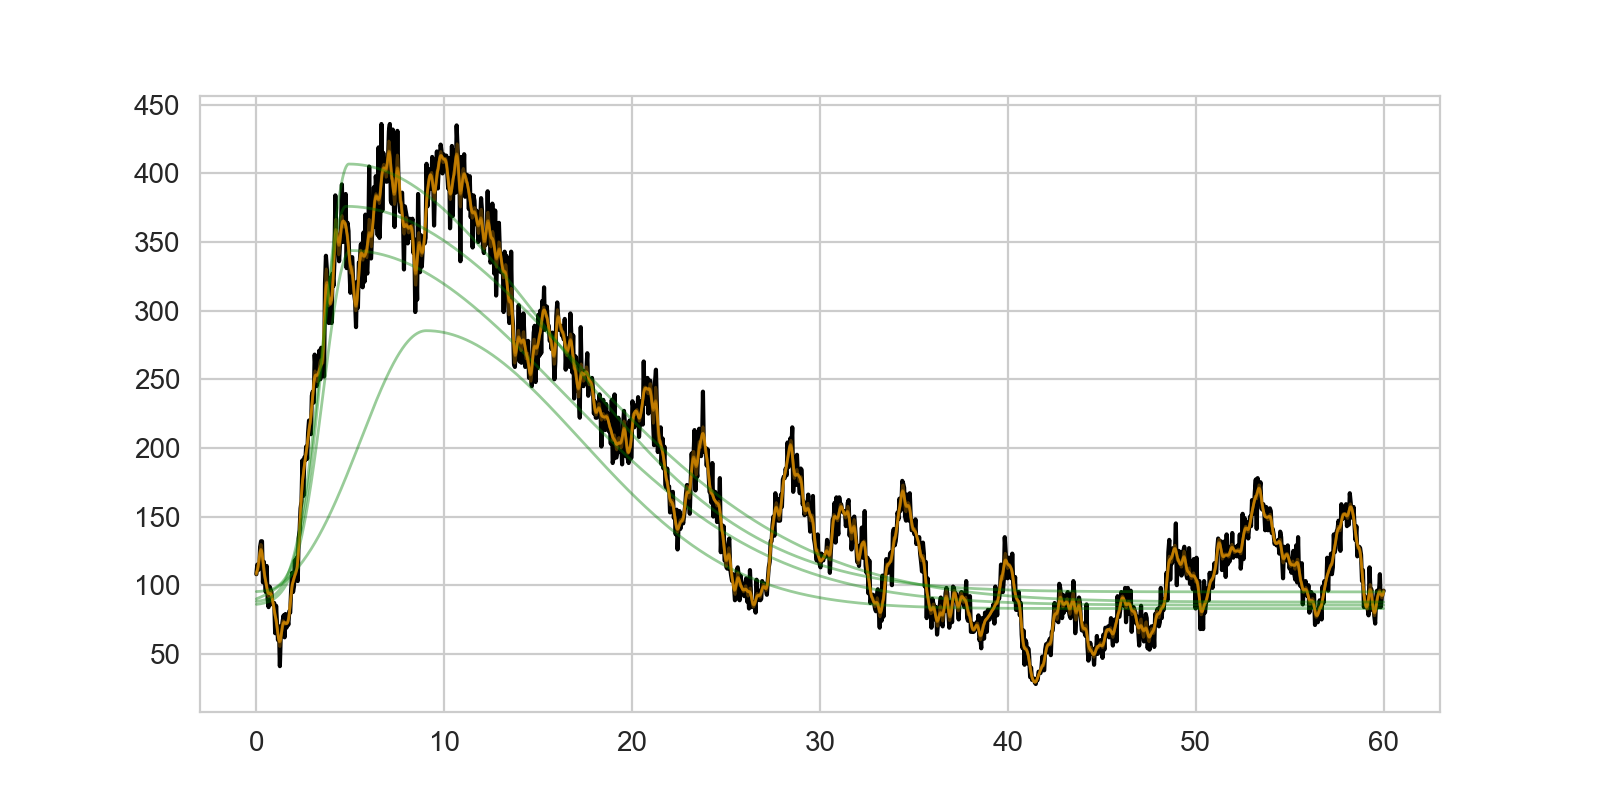

[Array(0.76278705, dtype=float64), Array(4.33842055, dtype=float64), Array(0.57979402, dtype=float64)]
[Array(0.76583726, dtype=float64), Array(4.548214, dtype=float64), Array(0.91863762, dtype=float64)]
[Array(8.67453728, dtype=float64), Array(7.24991653, dtype=float64), Array(4.05690967, dtype=float64)]
[Array(3.57801817, dtype=float64), Array(5.01278404, dtype=float64), Array(1.8055795, dtype=float64)]


In [201]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lcsample.time[:npoints], lcsample.counts[:npoints], color="black")

nsims = 4
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

tpost = np.linspace(0.0, time[-1], 2000)

for idx in idx_all:
    # mean parameters
    params = [samples["log_amp"][idx],
              samples["t0"][idx],
              samples["log_sig1"][idx],
              samples["log_sig2"][idx],
              samples["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx]),
             jnp.exp(samples["log_alpha3"][idx])]
    
    beta_post = jnp.exp(samples["log_beta"][idx])
    sigma_post = jnp.exp(samples["log_sigma"][idx])

    
    print(alpha_post)
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post, 
                        sigma=sigma_post)
    
    gp = GaussianProcess(kernel_post, lcsample.time[:npoints], diag=0.01)

    _, cond = gp.condition(lcsample.counts[:npoints], tpost, include_mean=True)

    ax.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.3)
    ax.plot(tpost, mean_post, lw=1, color="green", alpha=0.4)


It works! Hooray!

## Modeling the Real Data

To load the data, we'll have to read them from an IDL .sav file, which will return a dictionary with the relevant columns as keywords and the values in arrays:

In [17]:
#datadir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/data/"
datadir = "/Users/daniela/work/data/grb230307A/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
data

{'barytime': array([-6.87185967, -6.82185948, -6.77185976, ..., 98.02814186,
        98.07813728, 98.12814033], dtype='>f8'),
 'counts': array([4502., 4570., 4576., ..., 4516., 4444., 4514.], dtype='>f4')}

In [18]:
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

# calculate background flux
mean_bkg = np.mean(counts[-100:])
print(mean_bkg)

# store in Lightcurve object, then truncate to 0-60s interval:
lc = Lightcurve(barytime, counts)# -mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")

# calculate periodogram for comparison:
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-16 17:29:29,720]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-16 17:29:29,722]: Checking if light curve is sorted.
INFO[2023-10-16 17:29:29,723]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


4569.8


<IPython.core.display.Javascript object>


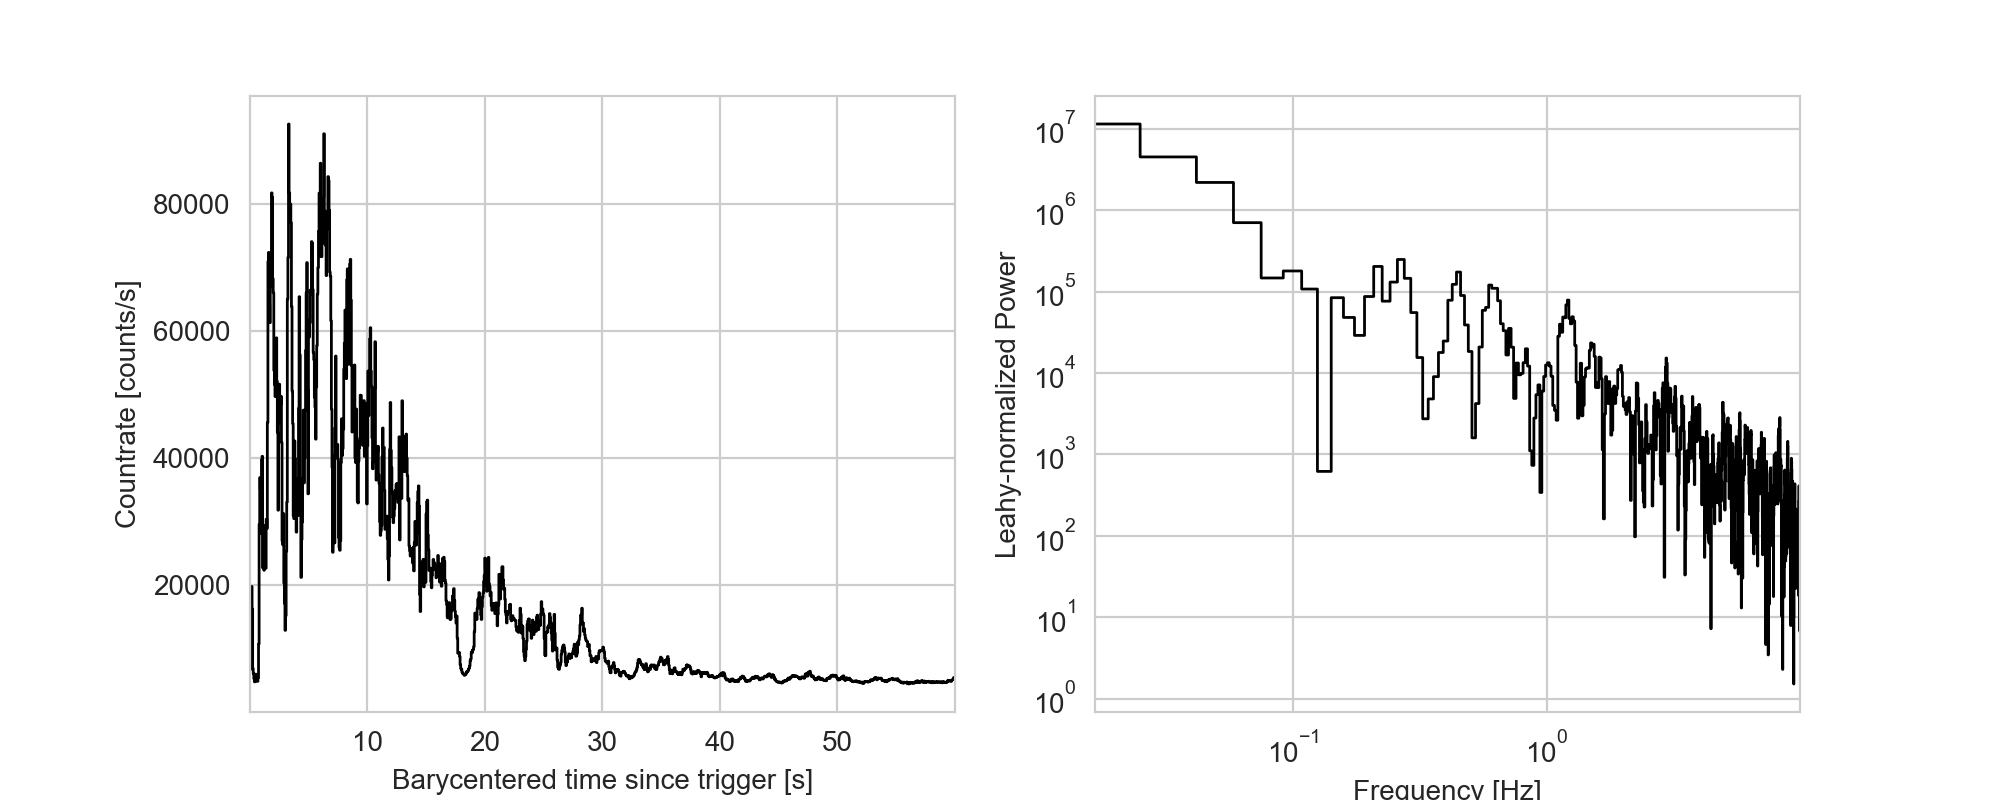

Text(0, 0.5, 'Leahy-normalized Power')

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [20]:
np.log(np.mean(lc.counts[-100:]))

8.468208808387544

In [21]:
np.exp(11.4)

89321.72336080558

In [22]:
np.log(np.max(lc.counts))

11.436109213351592

In [23]:
mean_bkg = np.log(np.mean(lc.counts[-100:]))

def carma32_integral(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(9, 12.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    # kernel parameters
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-10, 20))

    log_beta1 = numpyro.sample("log_beta1", dist.Uniform(-10, 20))
    log_beta2 = numpyro.sample("log_beta2", dist.Uniform(-10, 20))

    log_sigma = numpyro.sample("log_sigma", dist.Uniform(5, 15))
    
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
                        beta=[jnp.exp(log_beta1), jnp.exp(log_beta2)], sigma=jnp.exp(log_sigma))
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [24]:
npoints = len(lcsample.time)
ns = NestedSampler(carma32_integral)
ns.run(random.PRNGKey(1000), lc.time, y=lc.counts)

In [25]:
import pickle
with open(datadir + "integral_carma32_ns.pkl", "wb") as f:
    pickle.dump(ns, f)

In [26]:
samples, weights = ns.get_weighted_samples()

ns.print_summary()


--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 2271912
# samples: 10000
# slices: 293700.0
# slices / acceptance: 33.0
# likelihood evals / sample: 227.2
# likelihood evals / slice: 7.7
--------
logZ=-11621.74 +- 0.31
H=12000.0
ESS=1260
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 8.43 +- 0.28 | 8.1 / 8.42 / 8.73 | 8.62 | 8.62
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 7.93 +- 0.15 | 7.79 / 7.9 / 8.1 | 7.9 | 7.9
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 3.95 +- 0.17 | 3.76 / 3.93 / 4.15 | 3.93 | 3.93
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 10.705 +- 0.055 | 10.633 / 10.706 / 10.777 | 10.822 | 10.822
--------
log_beta1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta1: 5

pred[96]: 22000.0 +- 2300.0 | 19100.0 / 22000.0 / 25000.0 | 17100.0 | 17100.0
pred[97]: 26800.0 +- 2300.0 | 23800.0 / 26700.0 / 29700.0 | 21800.0 | 21800.0
pred[98]: 6800.0 +- 2300.0 | 3900.0 / 6800.0 / 9800.0 | 1900.0 | 1900.0
pred[99]: -9400.0 +- 2300.0 | -12300.0 / -9400.0 / -6400.0 | -14300.0 | -14300.0
pred[100]: 17800.0 +- 2300.0 | 14900.0 / 17800.0 / 20700.0 | 12900.0 | 12900.0
pred[101]: 15300.0 +- 2300.0 | 12400.0 / 15300.0 / 18300.0 | 10400.0 | 10400.0
pred[102]: 17500.0 +- 2300.0 | 14600.0 / 17500.0 / 20500.0 | 12600.0 | 12600.0
pred[103]: 22700.0 +- 2300.0 | 19800.0 / 22700.0 / 25600.0 | 17800.0 | 17800.0
pred[104]: 22000.0 +- 2300.0 | 19100.0 / 22000.0 / 25000.0 | 17200.0 | 17200.0
pred[105]: 30300.0 +- 2300.0 | 27400.0 / 30300.0 / 33300.0 | 25500.0 | 25500.0
pred[106]: 30100.0 +- 2300.0 | 27300.0 / 30100.0 / 33100.0 | 25300.0 | 25300.0
pred[107]: 22900.0 +- 2300.0 | 20000.0 / 22800.0 / 25800.0 | 18100.0 | 18100.0
pred[108]: 13000.0 +- 2300.0 | 10200.0 / 13000.0 / 16000.0 

pred[234]: -9500.0 +- 1800.0 | -11700.0 / -9700.0 / -7100.0 | -10400.0 | -10400.0
pred[235]: -12700.0 +- 1800.0 | -14900.0 / -12900.0 / -10300.0 | -13600.0 | -13600.0
pred[236]: -15900.0 +- 1800.0 | -18100.0 / -16000.0 / -13500.0 | -16700.0 | -16700.0
pred[237]: -12000.0 +- 1800.0 | -14200.0 / -12200.0 / -9600.0 | -12800.0 | -12800.0
pred[238]: 4800.0 +- 1800.0 | 2600.0 / 4600.0 / 7200.0 | 4000.0 | 4000.0
pred[239]: 12200.0 +- 1800.0 | 10000.0 / 12000.0 / 14700.0 | 11500.0 | 11500.0
pred[240]: 4800.0 +- 1800.0 | 2600.0 / 4600.0 / 7300.0 | 4100.0 | 4100.0
pred[241]: 2100.0 +- 1800.0 | -0.0 / 2000.0 / 4600.0 | 1500.0 | 1500.0
pred[242]: -1800.0 +- 1800.0 | -3900.0 / -1900.0 / 700.0 | -2300.0 | -2300.0
pred[243]: -5500.0 +- 1800.0 | -7700.0 / -5700.0 / -3100.0 | -6000.0 | -6000.0
pred[244]: -6300.0 +- 1800.0 | -8500.0 / -6500.0 / -3900.0 | -6800.0 | -6800.0
pred[245]: -5200.0 +- 1800.0 | -7400.0 / -5400.0 / -2800.0 | -5700.0 | -5700.0
pred[246]: -3900.0 +- 1800.0 | -6200.0 / -4100.0 / -15

pred[355]: -17900.0 +- 2300.0 | -21100.0 / -17800.0 / -15200.0 | -14800.0 | -14800.0
pred[356]: -17800.0 +- 2300.0 | -20900.0 / -17700.0 / -15100.0 | -14600.0 | -14600.0
pred[357]: -18300.0 +- 2300.0 | -21400.0 / -18200.0 / -15600.0 | -15100.0 | -15100.0
pred[358]: -19500.0 +- 2300.0 | -22700.0 / -19400.0 / -16800.0 | -16300.0 | -16300.0
pred[359]: -20100.0 +- 2300.0 | -23200.0 / -19900.0 / -17300.0 | -16800.0 | -16800.0
pred[360]: -20100.0 +- 2300.0 | -23300.0 / -20000.0 / -17400.0 | -16800.0 | -16800.0
pred[361]: -20500.0 +- 2300.0 | -23600.0 / -20300.0 / -17700.0 | -17200.0 | -17200.0
pred[362]: -20600.0 +- 2300.0 | -23800.0 / -20400.0 / -17800.0 | -17300.0 | -17300.0
pred[363]: -20600.0 +- 2300.0 | -23700.0 / -20400.0 / -17800.0 | -17200.0 | -17200.0
pred[364]: -20600.0 +- 2300.0 | -23700.0 / -20400.0 / -17800.0 | -17200.0 | -17200.0
pred[365]: -20600.0 +- 2300.0 | -23800.0 / -20500.0 / -17800.0 | -17200.0 | -17200.0
pred[366]: -20400.0 +- 2300.0 | -23700.0 / -20300.0 / -17600.0 | 

pred[495]: -900.0 +- 2900.0 | -4900.0 / -400.0 / 2500.0 | 4200.0 | 4200.0
pred[496]: 1100.0 +- 2900.0 | -2800.0 / 1600.0 / 4500.0 | 6200.0 | 6200.0
pred[497]: 100.0 +- 2900.0 | -3900.0 / 500.0 / 3400.0 | 5200.0 | 5200.0
pred[498]: 100.0 +- 2900.0 | -3900.0 / 600.0 / 3500.0 | 5200.0 | 5200.0
pred[499]: -500.0 +- 2900.0 | -4500.0 / -100.0 / 2800.0 | 4600.0 | 4600.0
pred[500]: -700.0 +- 2900.0 | -4700.0 / -300.0 / 2600.0 | 4400.0 | 4400.0
pred[501]: -4300.0 +- 2900.0 | -8300.0 / -3800.0 / -1000.0 | 800.0 | 800.0
pred[502]: -6900.0 +- 2900.0 | -10900.0 / -6400.0 / -3500.0 | -1700.0 | -1700.0
pred[503]: -6900.0 +- 2900.0 | -10900.0 / -6400.0 / -3600.0 | -1800.0 | -1800.0
pred[504]: -3200.0 +- 2900.0 | -7300.0 / -2800.0 / 100.0 | 1900.0 | 1900.0
pred[505]: -3000.0 +- 2900.0 | -7100.0 / -2600.0 / 300.0 | 2100.0 | 2100.0
pred[506]: -3000.0 +- 2900.0 | -7000.0 / -2500.0 / 300.0 | 2100.0 | 2100.0
pred[507]: -2100.0 +- 2900.0 | -6100.0 / -1600.0 / 1300.0 | 3000.0 | 3000.0
pred[508]: -2100.0 +- 29

pred[632]: -2300.0 +- 2600.0 | -6000.0 / -1700.0 / 500.0 | 2000.0 | 2000.0
pred[633]: -2100.0 +- 2600.0 | -5800.0 / -1500.0 / 700.0 | 2100.0 | 2100.0
pred[634]: -2100.0 +- 2600.0 | -5800.0 / -1500.0 / 700.0 | 2100.0 | 2100.0
pred[635]: -2000.0 +- 2600.0 | -5600.0 / -1300.0 / 800.0 | 2300.0 | 2300.0
pred[636]: -1900.0 +- 2600.0 | -5500.0 / -1200.0 / 900.0 | 2400.0 | 2400.0
pred[637]: -1900.0 +- 2500.0 | -5500.0 / -1200.0 / 900.0 | 2300.0 | 2300.0
pred[638]: -2000.0 +- 2500.0 | -5700.0 / -1400.0 / 700.0 | 2100.0 | 2100.0
pred[639]: -2100.0 +- 2500.0 | -5800.0 / -1500.0 / 700.0 | 2100.0 | 2100.0
pred[640]: -2300.0 +- 2500.0 | -5900.0 / -1700.0 / 500.0 | 1900.0 | 1900.0
pred[641]: -2400.0 +- 2500.0 | -6000.0 / -1800.0 / 400.0 | 1800.0 | 1800.0
pred[642]: -2400.0 +- 2500.0 | -6000.0 / -1700.0 / 400.0 | 1800.0 | 1800.0
pred[643]: -2300.0 +- 2500.0 | -5900.0 / -1700.0 / 400.0 | 1800.0 | 1800.0
pred[644]: -2200.0 +- 2500.0 | -5800.0 / -1500.0 / 600.0 | 1900.0 | 1900.0
pred[645]: -2500.0 +- 250

pred[773]: 2400.0 +- 1800.0 | -0.0 / 2900.0 / 4200.0 | 4800.0 | 4800.0
pred[774]: 2400.0 +- 1700.0 | -0.0 / 2900.0 / 4100.0 | 4800.0 | 4800.0
pred[775]: 2500.0 +- 1700.0 | 100.0 / 3000.0 / 4200.0 | 4900.0 | 4900.0
pred[776]: 2300.0 +- 1700.0 | -100.0 / 2800.0 / 4100.0 | 4700.0 | 4700.0
pred[777]: 2500.0 +- 1700.0 | 100.0 / 3000.0 / 4200.0 | 4800.0 | 4800.0
pred[778]: 2600.0 +- 1700.0 | 200.0 / 3100.0 / 4300.0 | 5000.0 | 5000.0
pred[779]: 2400.0 +- 1700.0 | 0.0 / 2900.0 / 4100.0 | 4700.0 | 4700.0
pred[780]: 2100.0 +- 1700.0 | -200.0 / 2600.0 / 3900.0 | 4500.0 | 4500.0
pred[781]: 2000.0 +- 1700.0 | -300.0 / 2500.0 / 3700.0 | 4300.0 | 4300.0
pred[782]: 2000.0 +- 1700.0 | -400.0 / 2500.0 / 3700.0 | 4300.0 | 4300.0
pred[783]: 2000.0 +- 1700.0 | -300.0 / 2500.0 / 3700.0 | 4300.0 | 4300.0
pred[784]: 2100.0 +- 1700.0 | -300.0 / 2500.0 / 3700.0 | 4300.0 | 4300.0
pred[785]: 2200.0 +- 1700.0 | -100.0 / 2700.0 / 3900.0 | 4500.0 | 4500.0
pred[786]: 2100.0 +- 1700.0 | -200.0 / 2600.0 / 3800.0 | 4400

pred[908]: 3260.0 +- 1000.0 | 1980.0 / 3560.0 / 4190.0 | 4310.0 | 4310.0
pred[909]: 3250.0 +- 990.0 | 1970.0 / 3550.0 / 4170.0 | 4290.0 | 4290.0
pred[910]: 3290.0 +- 990.0 | 2030.0 / 3590.0 / 4210.0 | 4330.0 | 4330.0
pred[911]: 3410.0 +- 980.0 | 2150.0 / 3710.0 / 4320.0 | 4440.0 | 4440.0
pred[912]: 3320.0 +- 980.0 | 2070.0 / 3620.0 / 4230.0 | 4340.0 | 4340.0
pred[913]: 3350.0 +- 970.0 | 2100.0 / 3640.0 / 4250.0 | 4360.0 | 4360.0
pred[914]: 3480.0 +- 970.0 | 2240.0 / 3770.0 / 4380.0 | 4480.0 | 4480.0
pred[915]: 3650.0 +- 960.0 | 2420.0 / 3940.0 / 4540.0 | 4650.0 | 4650.0
pred[916]: 3780.0 +- 960.0 | 2560.0 / 4070.0 / 4670.0 | 4770.0 | 4770.0
pred[917]: 3820.0 +- 950.0 | 2610.0 / 4120.0 / 4710.0 | 4810.0 | 4810.0
pred[918]: 3620.0 +- 950.0 | 2410.0 / 3910.0 / 4500.0 | 4590.0 | 4590.0
pred[919]: 3750.0 +- 950.0 | 2550.0 / 4040.0 / 4630.0 | 4720.0 | 4720.0
pred[920]: 3990.0 +- 940.0 | 2790.0 / 4280.0 / 4860.0 | 4950.0 | 4950.0
pred[921]: 4000.0 +- 940.0 | 2810.0 / 4280.0 / 4870.0 | 4960.0 

pred[1066]: 4600.0 +- 430.0 | 4120.0 / 4710.0 / 4990.0 | 4850.0 | 4850.0
pred[1067]: 4450.0 +- 430.0 | 3970.0 / 4560.0 / 4850.0 | 4700.0 | 4700.0
pred[1068]: 4560.0 +- 420.0 | 4090.0 / 4670.0 / 4950.0 | 4810.0 | 4810.0
pred[1069]: 4740.0 +- 420.0 | 4270.0 / 4850.0 / 5130.0 | 4980.0 | 4980.0
pred[1070]: 4710.0 +- 420.0 | 4250.0 / 4820.0 / 5100.0 | 4960.0 | 4960.0
pred[1071]: 4700.0 +- 420.0 | 4240.0 / 4810.0 / 5090.0 | 4940.0 | 4940.0
pred[1072]: 4660.0 +- 410.0 | 4200.0 / 4760.0 / 5040.0 | 4900.0 | 4900.0
pred[1073]: 4710.0 +- 410.0 | 4250.0 / 4810.0 / 5090.0 | 4940.0 | 4940.0
pred[1074]: 4730.0 +- 410.0 | 4280.0 / 4840.0 / 5120.0 | 4960.0 | 4960.0
pred[1075]: 4580.0 +- 410.0 | 4130.0 / 4690.0 / 4960.0 | 4810.0 | 4810.0
pred[1076]: 4380.0 +- 400.0 | 3930.0 / 4480.0 / 4760.0 | 4610.0 | 4610.0
pred[1077]: 4350.0 +- 400.0 | 3900.0 / 4450.0 / 4730.0 | 4570.0 | 4570.0
pred[1078]: 4340.0 +- 400.0 | 3890.0 / 4440.0 / 4710.0 | 4560.0 | 4560.0
pred[1079]: 4390.0 +- 400.0 | 3950.0 / 4490.0 / 477

pred[1182]: 4340.0 +- 220.0 | 4140.0 / 4350.0 / 4580.0 | 4360.0 | 4360.0
pred[1183]: 4250.0 +- 220.0 | 4050.0 / 4260.0 / 4490.0 | 4270.0 | 4270.0
pred[1184]: 4260.0 +- 220.0 | 4060.0 / 4270.0 / 4490.0 | 4280.0 | 4280.0
pred[1185]: 4310.0 +- 220.0 | 4110.0 / 4320.0 / 4540.0 | 4320.0 | 4320.0
pred[1186]: 4410.0 +- 220.0 | 4210.0 / 4420.0 / 4640.0 | 4420.0 | 4420.0
pred[1187]: 4360.0 +- 220.0 | 4170.0 / 4370.0 / 4600.0 | 4380.0 | 4380.0
pred[1188]: 4630.0 +- 210.0 | 4430.0 / 4640.0 / 4860.0 | 4640.0 | 4640.0
pred[1189]: 4490.0 +- 210.0 | 4300.0 / 4500.0 / 4730.0 | 4510.0 | 4510.0
pred[1190]: 4580.0 +- 210.0 | 4390.0 / 4590.0 / 4810.0 | 4590.0 | 4590.0
pred[1191]: 4630.0 +- 210.0 | 4440.0 / 4640.0 / 4860.0 | 4640.0 | 4640.0
pred[1192]: 4590.0 +- 210.0 | 4400.0 / 4600.0 / 4820.0 | 4600.0 | 4600.0
pred[1193]: 4440.0 +- 210.0 | 4250.0 / 4450.0 / 4670.0 | 4450.0 | 4450.0
pred[1194]: 4640.0 +- 210.0 | 4450.0 / 4650.0 / 4870.0 | 4650.0 | 4650.0
pred[1195]: 4700.0 +- 210.0 | 4510.0 / 4710.0 / 493

<IPython.core.display.Javascript object>


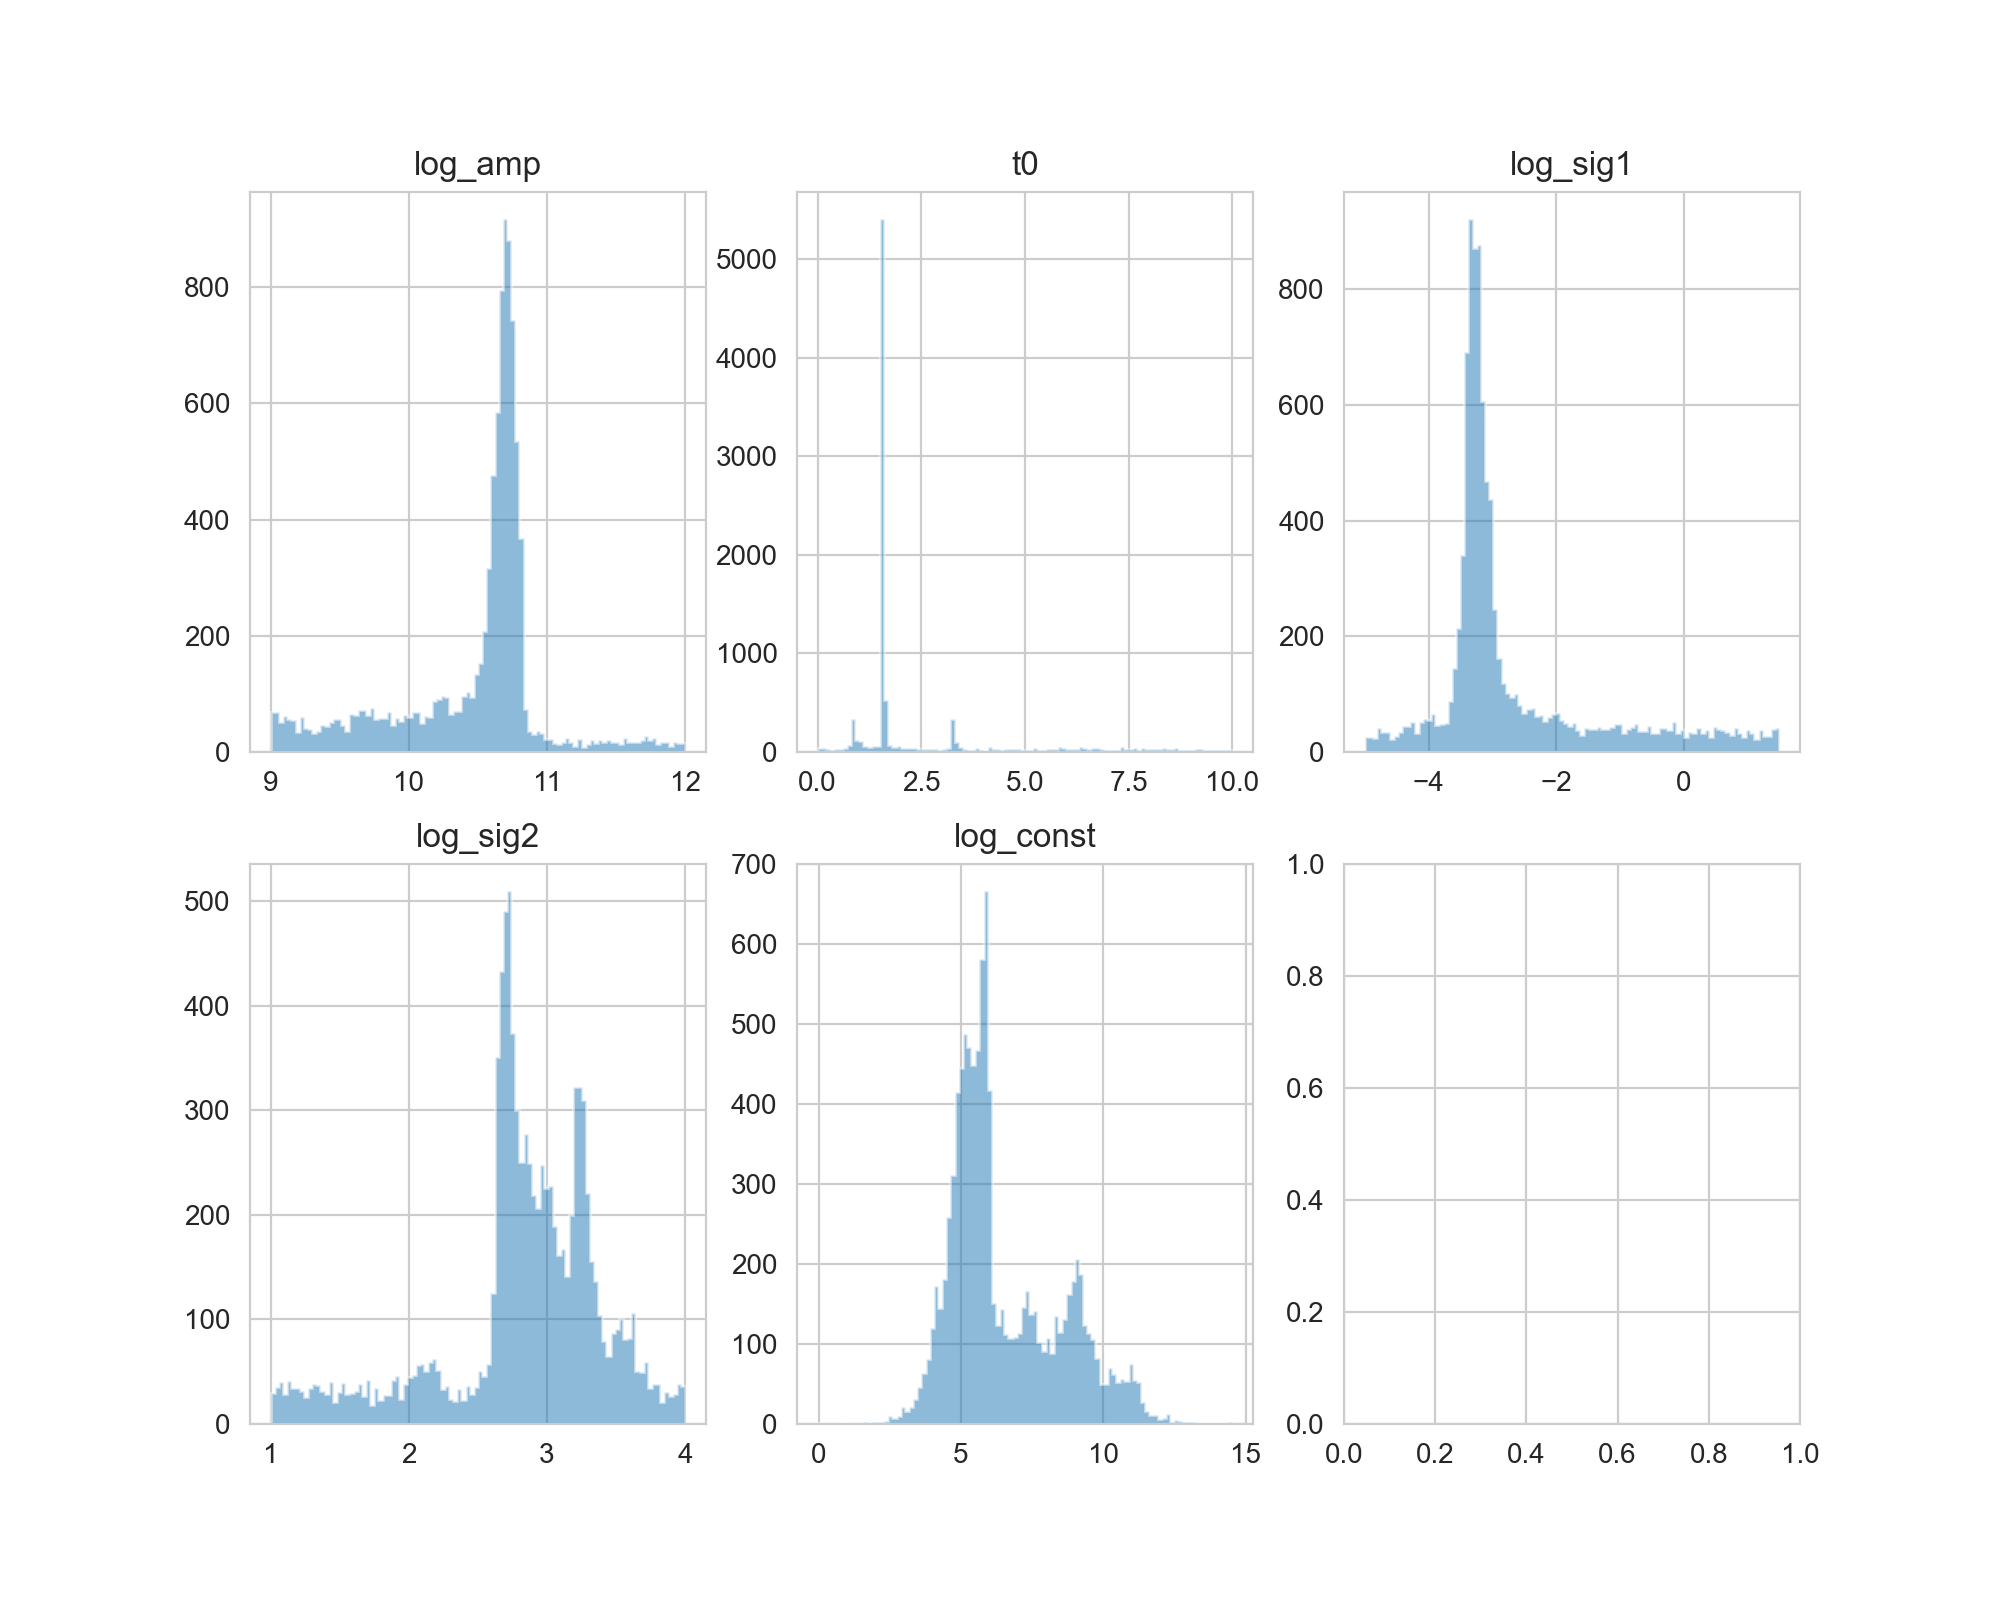

In [27]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


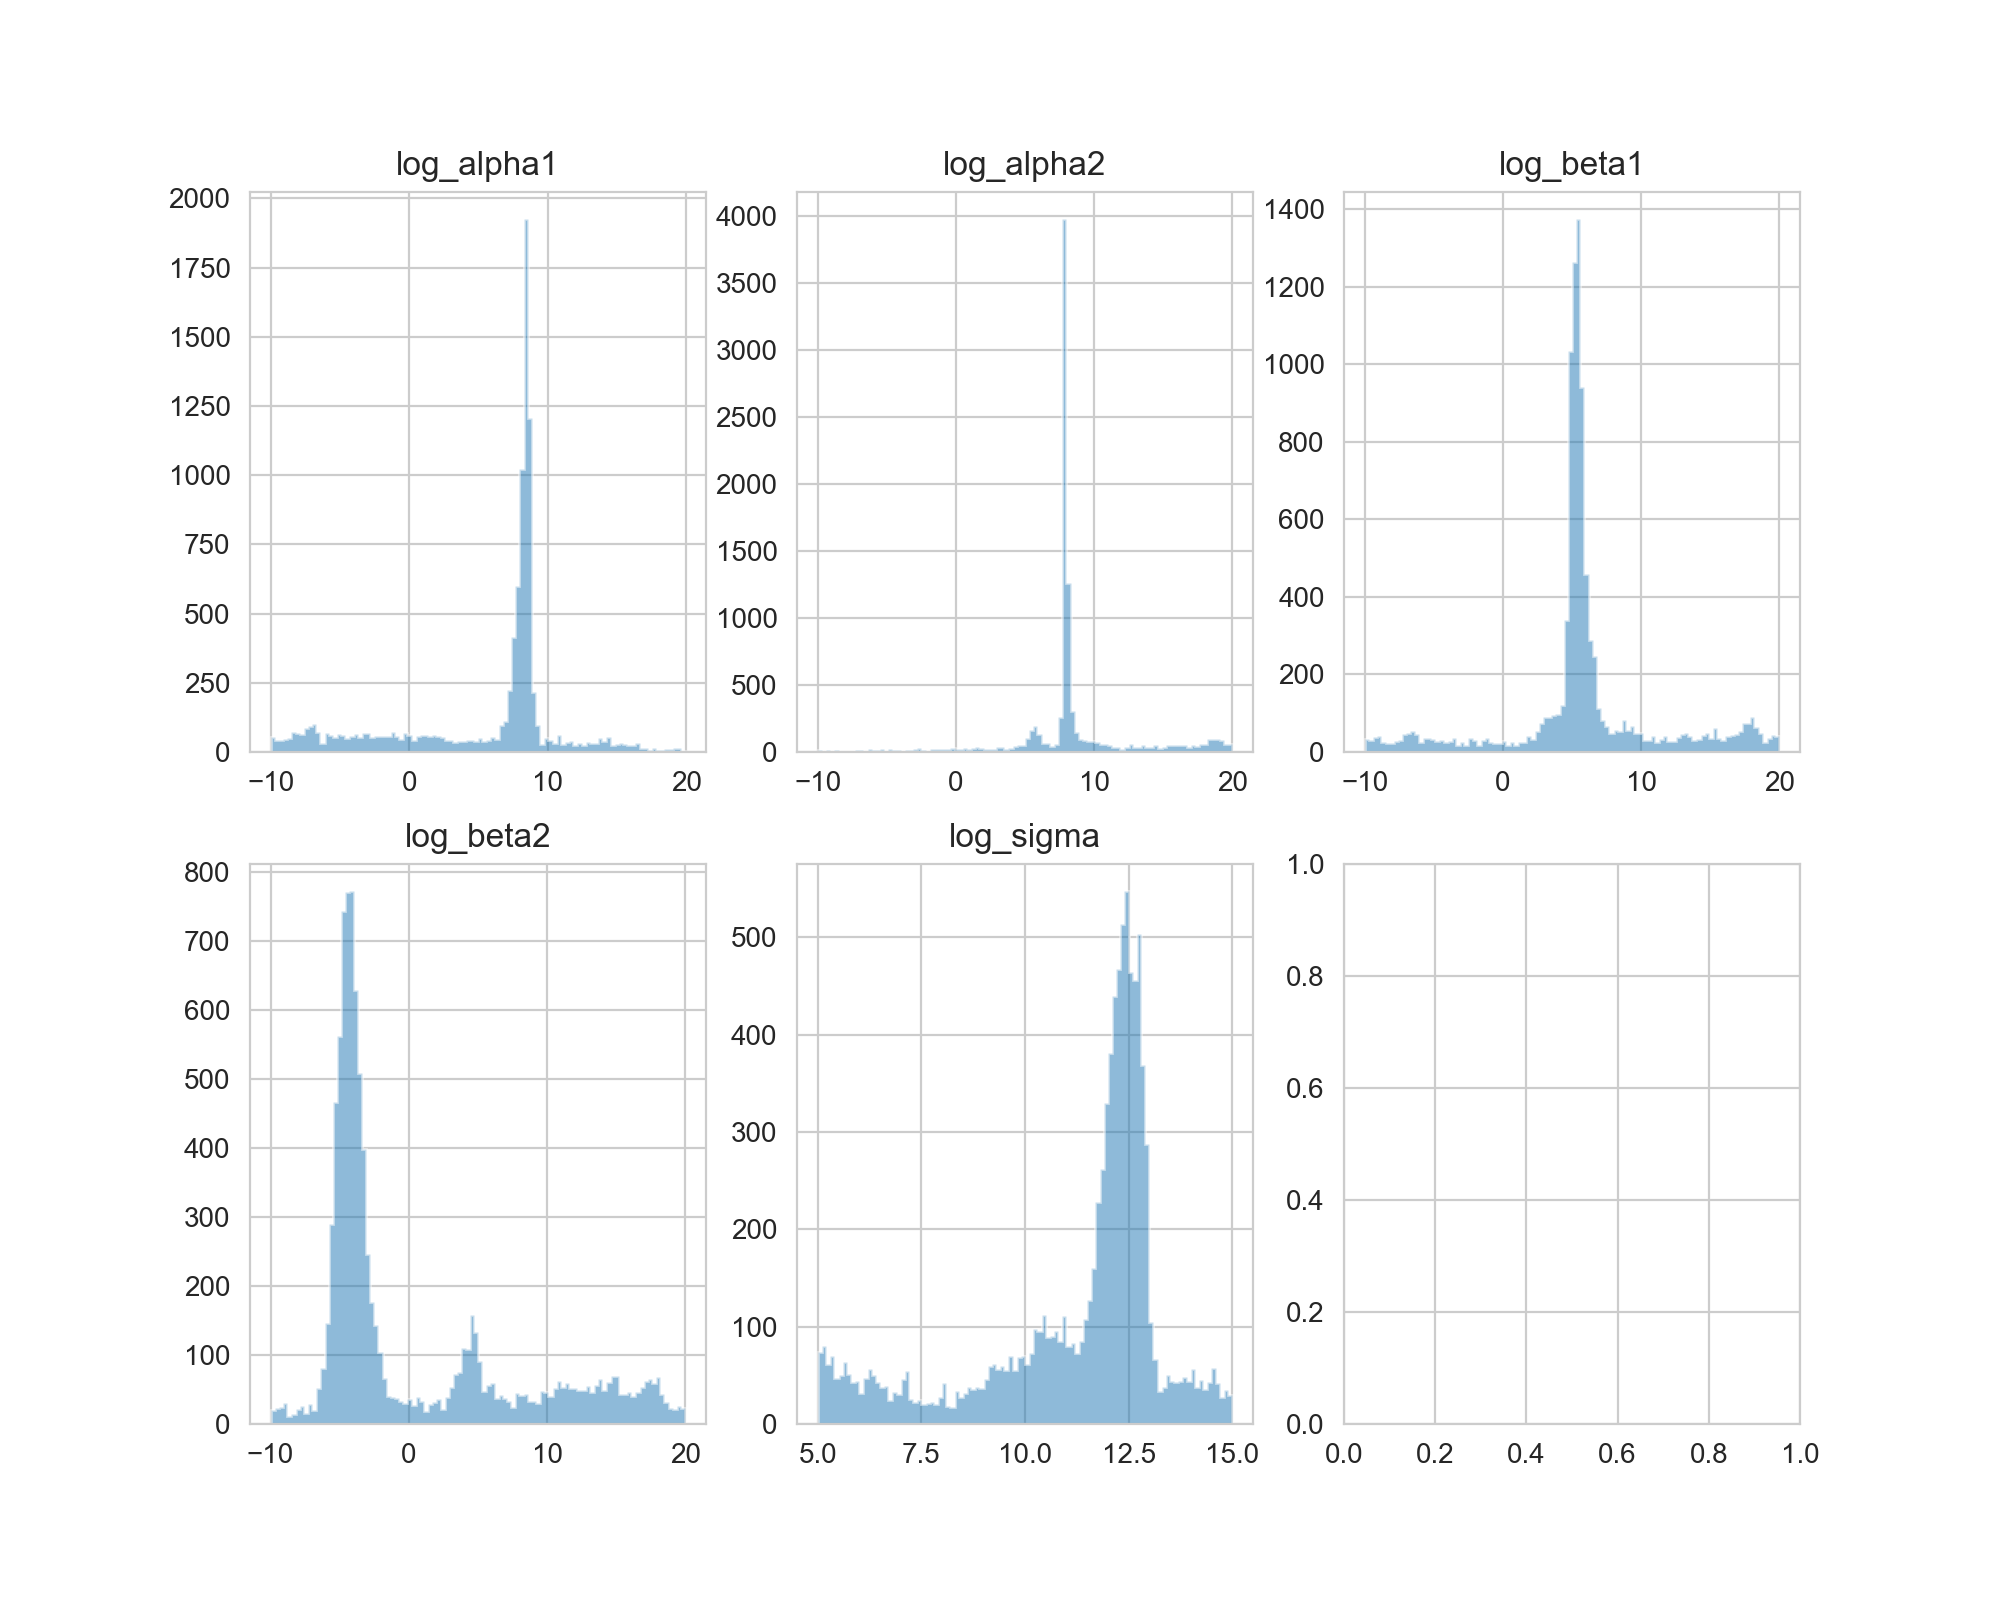

In [28]:
kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta1", "log_beta2", "log_sigma",]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

Let's include a function to compute the PSD:

In [29]:
def power_spectrum(freq, sigma, ar_coef, ma_coefs=[1.0]):
    """
    FROM CARMApack (Kelly et al, 2014)
    
    Return the power spectrum for a CARMA(p,q) process calculated at the input frequencies.

    :param freq: The frequencies at which to calculate the PSD.
    :param sigma: The standard deviation driving white noise.
    :param ar_coef: The CARMA model autoregressive coefficients.
    :param ma_coefs: Coefficients of the moving average polynomial

    :rtype : The power spectrum at the input frequencies, a numpy array.
    """
    try:
        len(ma_coefs) <= len(ar_coef)
    except ValueError:
        "Size of ma_coefs must be less or equal to size of ar_roots."

    ma_poly = np.polyval(ma_coefs[::-1], 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD numerator
    ar_poly = np.polyval(ar_coef, 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD denominator
    pspec = sigma ** 2 * np.abs(ma_poly) ** 2 / np.abs(ar_poly) ** 2
    return pspec

<IPython.core.display.Javascript object>


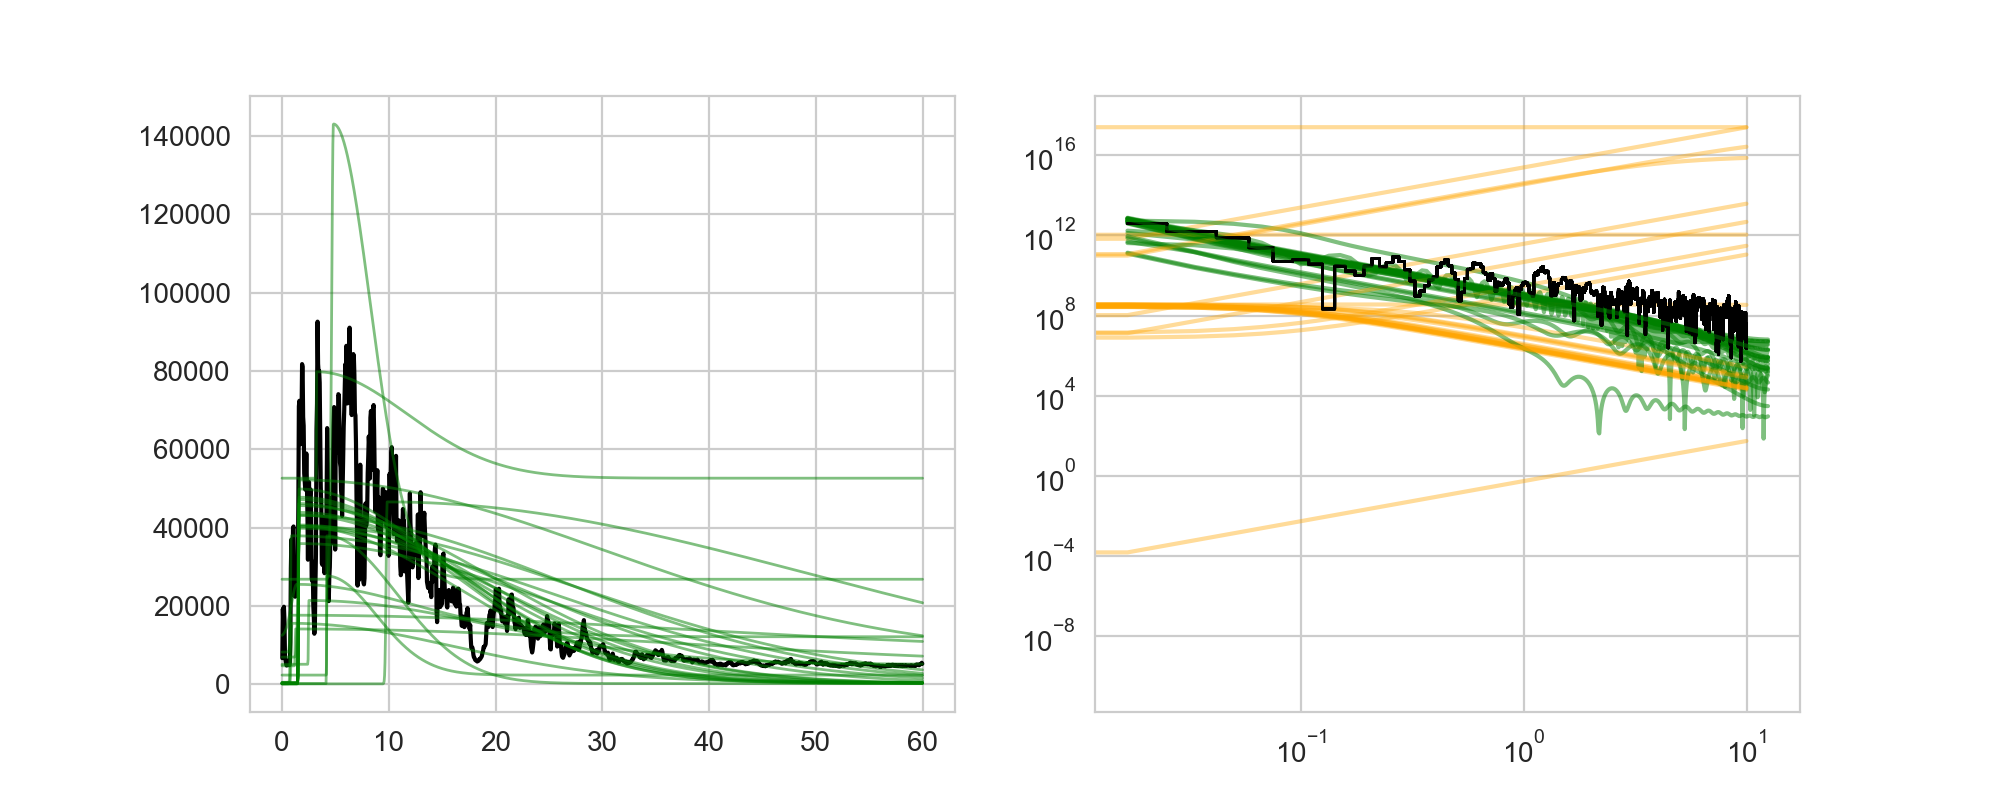

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time[:npoints], lc.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc.n, d=lc.dt)
freq = freq[:int(lc.n/2)]
# calculate periodogram for comparison:
ps = Powerspectrum(lc, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples["log_amp"][idx],
              samples["t0"][idx],
              samples["log_sig1"][idx],
              samples["log_sig2"][idx],
              samples["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx])]
    
    beta_post = [jnp.exp(samples["log_beta1"][idx]),
                 jnp.exp(samples["log_beta2"][idx])]
    sigma_post = jnp.exp(samples["log_sigma"][idx])

    
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post, 
                        sigma=sigma_post)
    
    gp = GaussianProcess(kernel_post, lc.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    psd = power_spectrum(freq, sigma_post, alpha_post, ma_coefs=beta_post)
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps.freq, ps.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)


**To do**: 
* make a PSD of the process here (DONE)
* compare to model with QPO
* try other CARMA processesa

## A model with a QPO

Let's now add a model with a QPO:

In [21]:
mean_bkg = np.log(np.mean(lc.counts[-100:]))

def model_integral_with_qpo(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(9, 12.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    # kernel parameters
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    log_alpha3 = numpyro.sample("log_alpha3", dist.Uniform(-10, 20))

    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(5, 15))

    # CARMA kernel
    kernel_carma = CARMA.init(
        alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2), jnp.exp(log_alpha3)], 
        beta=[jnp.exp(log_beta)], 
        sigma=jnp.exp(log_sigma)

    )
    
    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_cqpo = numpyro.sample("log_cqpo", dist.Uniform(-10, 2))
    log_freq = numpyro.sample("log_freq", dist.Uniform(np.log(0.1), np.log(5)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=jnp.exp(log_aqpo),
            b=0.0,
            c=jnp.exp(log_cqpo),
            d=2 * jnp.pi * jnp.exp(log_freq),
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo
    
    # gaussian process
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [ ]:
npoints = lc.n
ns_qpo = NestedSampler(model_integral_with_qpo)
ns_qpo.run(random.PRNGKey(2), lc.time[:npoints], y=lc.counts[:npoints])

In [367]:
samples_qpo, weights_qpo = ns_qpo.get_weighted_samples()

ns_qpo.print_summary()


--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1751518
# samples: 10000
# slices: 339300.0
# slices / acceptance: 39.0
# likelihood evals / sample: 175.2
# likelihood evals / slice: 5.1
--------
logZ=-11626.23 +- 0.28
H=12000.0
ESS=989
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 13.96 +- 0.99 | 12.92 / 14.22 / 14.85 | 14.68 | 14.68
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 12.66 +- 0.97 | 11.53 / 12.95 / 13.56 | 13.29 | 13.29
--------
log_alpha3: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha3: 8.42 +- 0.93 | 7.36 / 8.67 / 9.31 | 9.07 | 9.07
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 10.834 +- 0.058 | 10.757 / 10.837 / 10.909 | 10.831 | 10.831
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) es

pred[169]: 15900.0 +- 1800.0 | 13500.0 / 15900.0 / 18200.0 | 15400.0 | 15400.0
pred[170]: 23900.0 +- 1800.0 | 21600.0 / 24000.0 / 26200.0 | 23500.0 | 23500.0
pred[171]: 24800.0 +- 1800.0 | 22500.0 / 24900.0 / 27100.0 | 24400.0 | 24400.0
pred[172]: 18500.0 +- 1800.0 | 16200.0 / 18600.0 / 20800.0 | 18100.0 | 18100.0
pred[173]: 8400.0 +- 1800.0 | 6100.0 / 8500.0 / 10600.0 | 8000.0 | 8000.0
pred[174]: -1900.0 +- 1800.0 | -4200.0 / -1800.0 / 300.0 | -2400.0 | -2400.0
pred[175]: -1500.0 +- 1800.0 | -3800.0 / -1500.0 / 700.0 | -2000.0 | -2000.0
pred[176]: 600.0 +- 1800.0 | -1700.0 / 600.0 / 2800.0 | 100.0 | 100.0
pred[177]: 4400.0 +- 1800.0 | 2100.0 / 4400.0 / 6600.0 | 3900.0 | 3900.0
pred[178]: 9100.0 +- 1800.0 | 6900.0 / 9200.0 / 11300.0 | 8700.0 | 8700.0
pred[179]: -5300.0 +- 1700.0 | -7500.0 / -5200.0 / -3100.0 | -5800.0 | -5800.0
pred[180]: -5800.0 +- 1700.0 | -8000.0 / -5800.0 / -3700.0 | -6300.0 | -6300.0
pred[181]: 2700.0 +- 1700.0 | 500.0 / 2700.0 / 4800.0 | 2200.0 | 2200.0
pred[182]

pred[303]: 1500.0 +- 1800.0 | -800.0 / 1400.0 / 3900.0 | 700.0 | 700.0
pred[304]: -700.0 +- 1800.0 | -3000.0 / -800.0 / 1700.0 | -1500.0 | -1500.0
pred[305]: -3800.0 +- 1800.0 | -6100.0 / -3900.0 / -1400.0 | -4600.0 | -4600.0
pred[306]: -3700.0 +- 1900.0 | -6000.0 / -3800.0 / -1300.0 | -4500.0 | -4500.0
pred[307]: -3200.0 +- 1900.0 | -5500.0 / -3200.0 / -700.0 | -4000.0 | -4000.0
pred[308]: -5200.0 +- 1900.0 | -7400.0 / -5200.0 / -2700.0 | -6000.0 | -6000.0
pred[309]: -6000.0 +- 1900.0 | -8300.0 / -6100.0 / -3500.0 | -6800.0 | -6800.0
pred[310]: -3900.0 +- 1900.0 | -6200.0 / -4000.0 / -1400.0 | -4700.0 | -4700.0
pred[311]: -2900.0 +- 1900.0 | -5100.0 / -2900.0 / -300.0 | -3700.0 | -3700.0
pred[312]: -1100.0 +- 1900.0 | -3400.0 / -1200.0 / 1400.0 | -1900.0 | -1900.0
pred[313]: -1900.0 +- 1900.0 | -4200.0 / -1900.0 / 700.0 | -2700.0 | -2700.0
pred[314]: -1400.0 +- 1900.0 | -3700.0 / -1500.0 / 1100.0 | -2200.0 | -2200.0
pred[315]: -1800.0 +- 1900.0 | -4000.0 / -1800.0 / 800.0 | -2500.0 | 

pred[435]: 3100.0 +- 1400.0 | 1300.0 / 3200.0 / 5000.0 | 2800.0 | 2800.0
pred[436]: 2700.0 +- 1400.0 | 900.0 / 2800.0 / 4500.0 | 2400.0 | 2400.0
pred[437]: 1500.0 +- 1400.0 | -200.0 / 1600.0 / 3400.0 | 1200.0 | 1200.0
pred[438]: 2900.0 +- 1400.0 | 1200.0 / 3000.0 / 4700.0 | 2600.0 | 2600.0
pred[439]: 3500.0 +- 1400.0 | 1700.0 / 3500.0 / 5300.0 | 3200.0 | 3200.0
pred[440]: 3400.0 +- 1400.0 | 1700.0 / 3400.0 / 5200.0 | 3100.0 | 3100.0
pred[441]: 3700.0 +- 1400.0 | 2000.0 / 3700.0 / 5500.0 | 3400.0 | 3400.0
pred[442]: 4700.0 +- 1400.0 | 3000.0 / 4700.0 / 6500.0 | 4400.0 | 4400.0
pred[443]: 4900.0 +- 1400.0 | 3200.0 / 4900.0 / 6600.0 | 4600.0 | 4600.0
pred[444]: 2600.0 +- 1300.0 | 900.0 / 2600.0 / 4400.0 | 2300.0 | 2300.0
pred[445]: 2400.0 +- 1300.0 | 700.0 / 2400.0 / 4100.0 | 2100.0 | 2100.0
pred[446]: 3200.0 +- 1300.0 | 1500.0 / 3200.0 / 4900.0 | 2900.0 | 2900.0
pred[447]: 3300.0 +- 1300.0 | 1600.0 / 3300.0 / 5000.0 | 3000.0 | 3000.0
pred[448]: 2900.0 +- 1300.0 | 1200.0 / 2900.0 / 4600.0

pred[647]: -1080.0 +- 990.0 | -2340.0 / -1030.0 / 140.0 | -960.0 | -960.0
pred[648]: -770.0 +- 990.0 | -2040.0 / -720.0 / 450.0 | -640.0 | -640.0
pred[649]: -800.0 +- 990.0 | -2060.0 / -740.0 / 430.0 | -670.0 | -670.0
pred[650]: -980.0 +- 1000.0 | -2250.0 / -920.0 / 250.0 | -850.0 | -850.0
pred[651]: -830.0 +- 1000.0 | -2100.0 / -770.0 / 400.0 | -690.0 | -690.0
pred[652]: -740.0 +- 1000.0 | -2020.0 / -680.0 / 490.0 | -610.0 | -610.0
pred[653]: -720.0 +- 1000.0 | -2010.0 / -670.0 / 510.0 | -590.0 | -590.0
pred[654]: -440.0 +- 1000.0 | -1720.0 / -380.0 / 800.0 | -310.0 | -310.0
pred[655]: -200.0 +- 1000.0 | -1500.0 / -200.0 / 1000.0 | -100.0 | -100.0
pred[656]: 0.0 +- 1000.0 | -1300.0 / 100.0 / 1300.0 | 200.0 | 200.0
pred[657]: 0.0 +- 1000.0 | -1300.0 / 100.0 / 1300.0 | 200.0 | 200.0
pred[658]: 300.0 +- 1000.0 | -1000.0 / 400.0 / 1600.0 | 500.0 | 500.0
pred[659]: 800.0 +- 1000.0 | -500.0 / 800.0 / 2000.0 | 900.0 | 900.0
pred[660]: 1400.0 +- 1000.0 | 100.0 / 1400.0 / 2600.0 | 1500.0 | 150

pred[784]: -400.0 +- 1100.0 | -1900.0 / -300.0 / 1000.0 | -300.0 | -300.0
pred[785]: -200.0 +- 1100.0 | -1700.0 / -100.0 / 1200.0 | -100.0 | -100.0
pred[786]: -400.0 +- 1100.0 | -1800.0 / -300.0 / 1000.0 | -200.0 | -200.0
pred[787]: -200.0 +- 1100.0 | -1700.0 / -100.0 / 1200.0 | -100.0 | -100.0
pred[788]: -500.0 +- 1100.0 | -1900.0 / -400.0 / 900.0 | -300.0 | -300.0
pred[789]: -500.0 +- 1100.0 | -1900.0 / -400.0 / 1000.0 | -300.0 | -300.0
pred[790]: -500.0 +- 1100.0 | -2000.0 / -400.0 / 900.0 | -400.0 | -400.0
pred[791]: -600.0 +- 1100.0 | -2100.0 / -500.0 / 800.0 | -500.0 | -500.0
pred[792]: -500.0 +- 1100.0 | -2000.0 / -500.0 / 900.0 | -400.0 | -400.0
pred[793]: -600.0 +- 1100.0 | -2000.0 / -500.0 / 800.0 | -400.0 | -400.0
pred[794]: -500.0 +- 1100.0 | -2000.0 / -400.0 / 900.0 | -400.0 | -400.0
pred[795]: -300.0 +- 1100.0 | -1800.0 / -300.0 / 1100.0 | -200.0 | -200.0
pred[796]: -400.0 +- 1100.0 | -1800.0 / -300.0 / 1000.0 | -200.0 | -200.0
pred[797]: -300.0 +- 1100.0 | -1800.0 / -300

pred[949]: -300.0 +- 1100.0 | -1700.0 / -200.0 / 1200.0 | -100.0 | -100.0
pred[950]: 300.0 +- 1100.0 | -1200.0 / 400.0 / 1700.0 | 400.0 | 400.0
pred[951]: 400.0 +- 1100.0 | -1100.0 / 500.0 / 1800.0 | 500.0 | 500.0
pred[952]: 400.0 +- 1100.0 | -1100.0 / 500.0 / 1800.0 | 500.0 | 500.0
pred[953]: 500.0 +- 1100.0 | -1000.0 / 600.0 / 1900.0 | 600.0 | 600.0
pred[954]: 100.0 +- 1100.0 | -1400.0 / 200.0 / 1500.0 | 200.0 | 200.0
pred[955]: -200.0 +- 1100.0 | -1700.0 / -100.0 / 1300.0 | -0.0 | -0.0
pred[956]: -400.0 +- 1100.0 | -1800.0 / -300.0 / 1100.0 | -200.0 | -200.0
pred[957]: -300.0 +- 1100.0 | -1800.0 / -200.0 / 1100.0 | -200.0 | -200.0
pred[958]: -200.0 +- 1100.0 | -1700.0 / -100.0 / 1200.0 | -100.0 | -100.0
pred[959]: -400.0 +- 1100.0 | -1900.0 / -300.0 / 1000.0 | -300.0 | -300.0
pred[960]: -600.0 +- 1100.0 | -2100.0 / -500.0 / 800.0 | -500.0 | -500.0
pred[961]: -700.0 +- 1100.0 | -2100.0 / -600.0 / 800.0 | -500.0 | -500.0
pred[962]: -900.0 +- 1100.0 | -2300.0 / -800.0 / 600.0 | -700.0 

pred[1157]: -1200.0 +- 1100.0 | -2700.0 / -1100.0 / 200.0 | -1100.0 | -1100.0
pred[1158]: -1200.0 +- 1100.0 | -2700.0 / -1100.0 / 200.0 | -1100.0 | -1100.0
pred[1159]: -1300.0 +- 1100.0 | -2800.0 / -1200.0 / 200.0 | -1100.0 | -1100.0
pred[1160]: -1100.0 +- 1100.0 | -2600.0 / -1000.0 / 300.0 | -1000.0 | -1000.0
pred[1161]: -1300.0 +- 1100.0 | -2800.0 / -1200.0 / 100.0 | -1200.0 | -1200.0
pred[1162]: -1300.0 +- 1100.0 | -2800.0 / -1200.0 / 100.0 | -1200.0 | -1200.0
pred[1163]: -1100.0 +- 1100.0 | -2600.0 / -1000.0 / 300.0 | -1000.0 | -1000.0
pred[1164]: -1300.0 +- 1100.0 | -2800.0 / -1200.0 / 100.0 | -1200.0 | -1200.0
pred[1165]: -1300.0 +- 1100.0 | -2800.0 / -1200.0 / 200.0 | -1100.0 | -1100.0
pred[1166]: -1200.0 +- 1100.0 | -2700.0 / -1100.0 / 300.0 | -1000.0 | -1000.0
pred[1167]: -1200.0 +- 1100.0 | -2600.0 / -1100.0 / 300.0 | -1000.0 | -1000.0
pred[1168]: -1200.0 +- 1100.0 | -2700.0 / -1100.0 / 200.0 | -1100.0 | -1100.0
pred[1169]: -1200.0 +- 1100.0 | -2600.0 / -1000.0 / 300.0 | -100

In [368]:
logZ_carma= -11631.82
logZ_qpo =-11626.23

In [369]:
logZ_carma - logZ_qpo

13.75

<IPython.core.display.Javascript object>


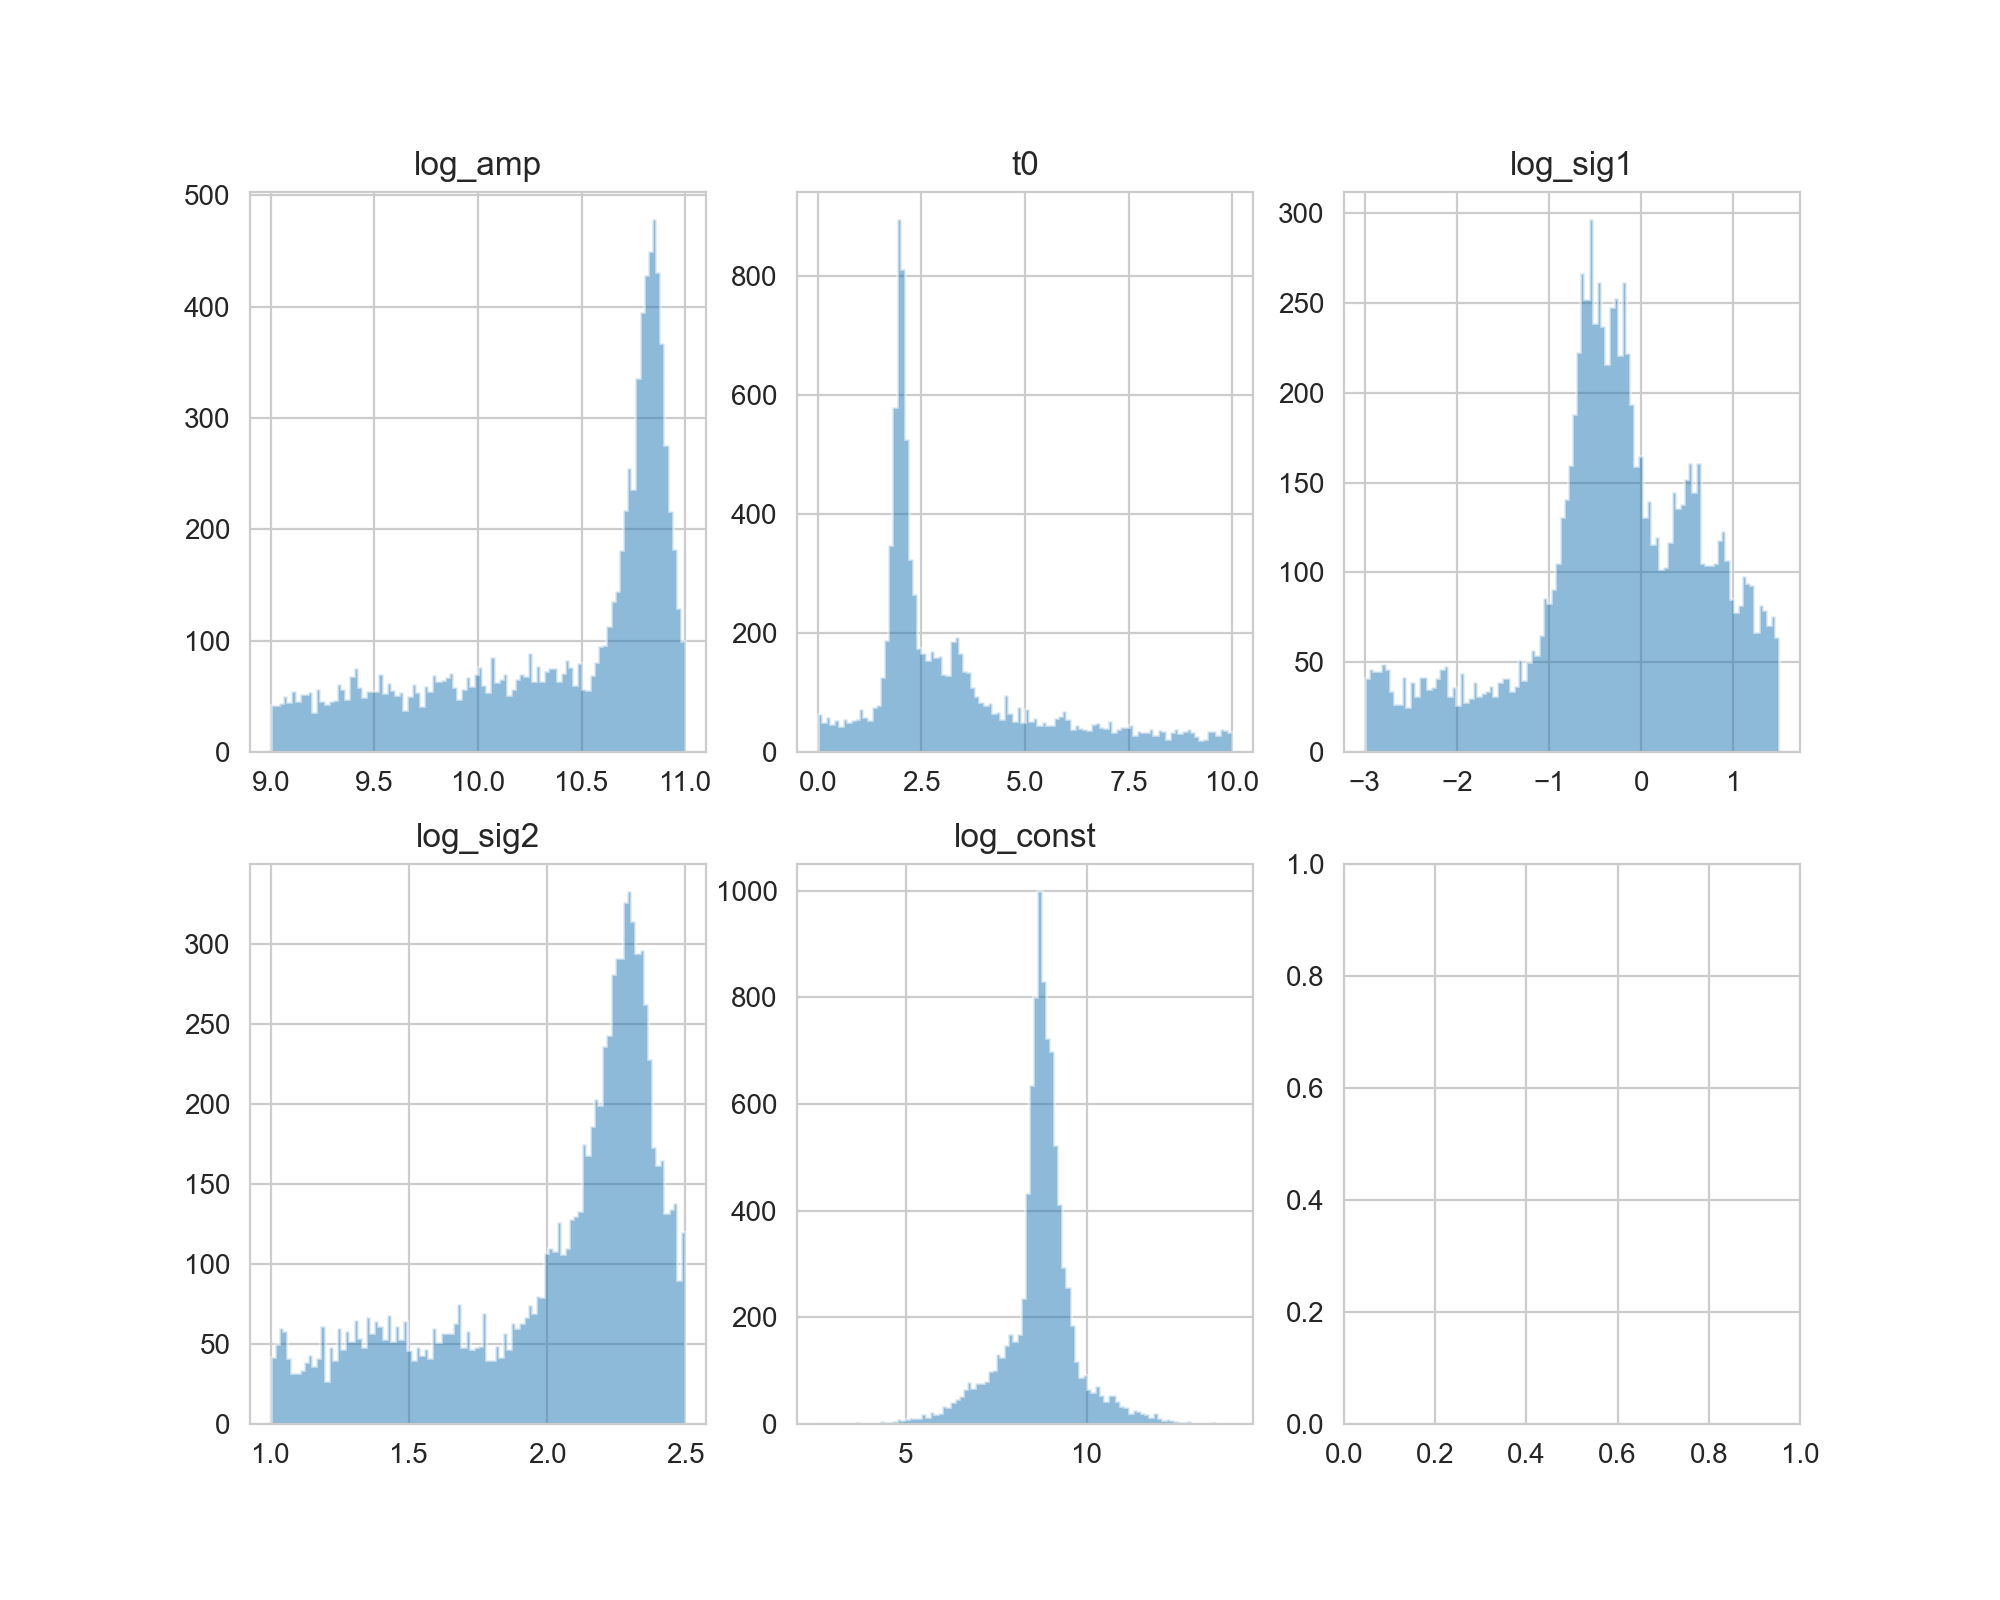

In [370]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples_qpo[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


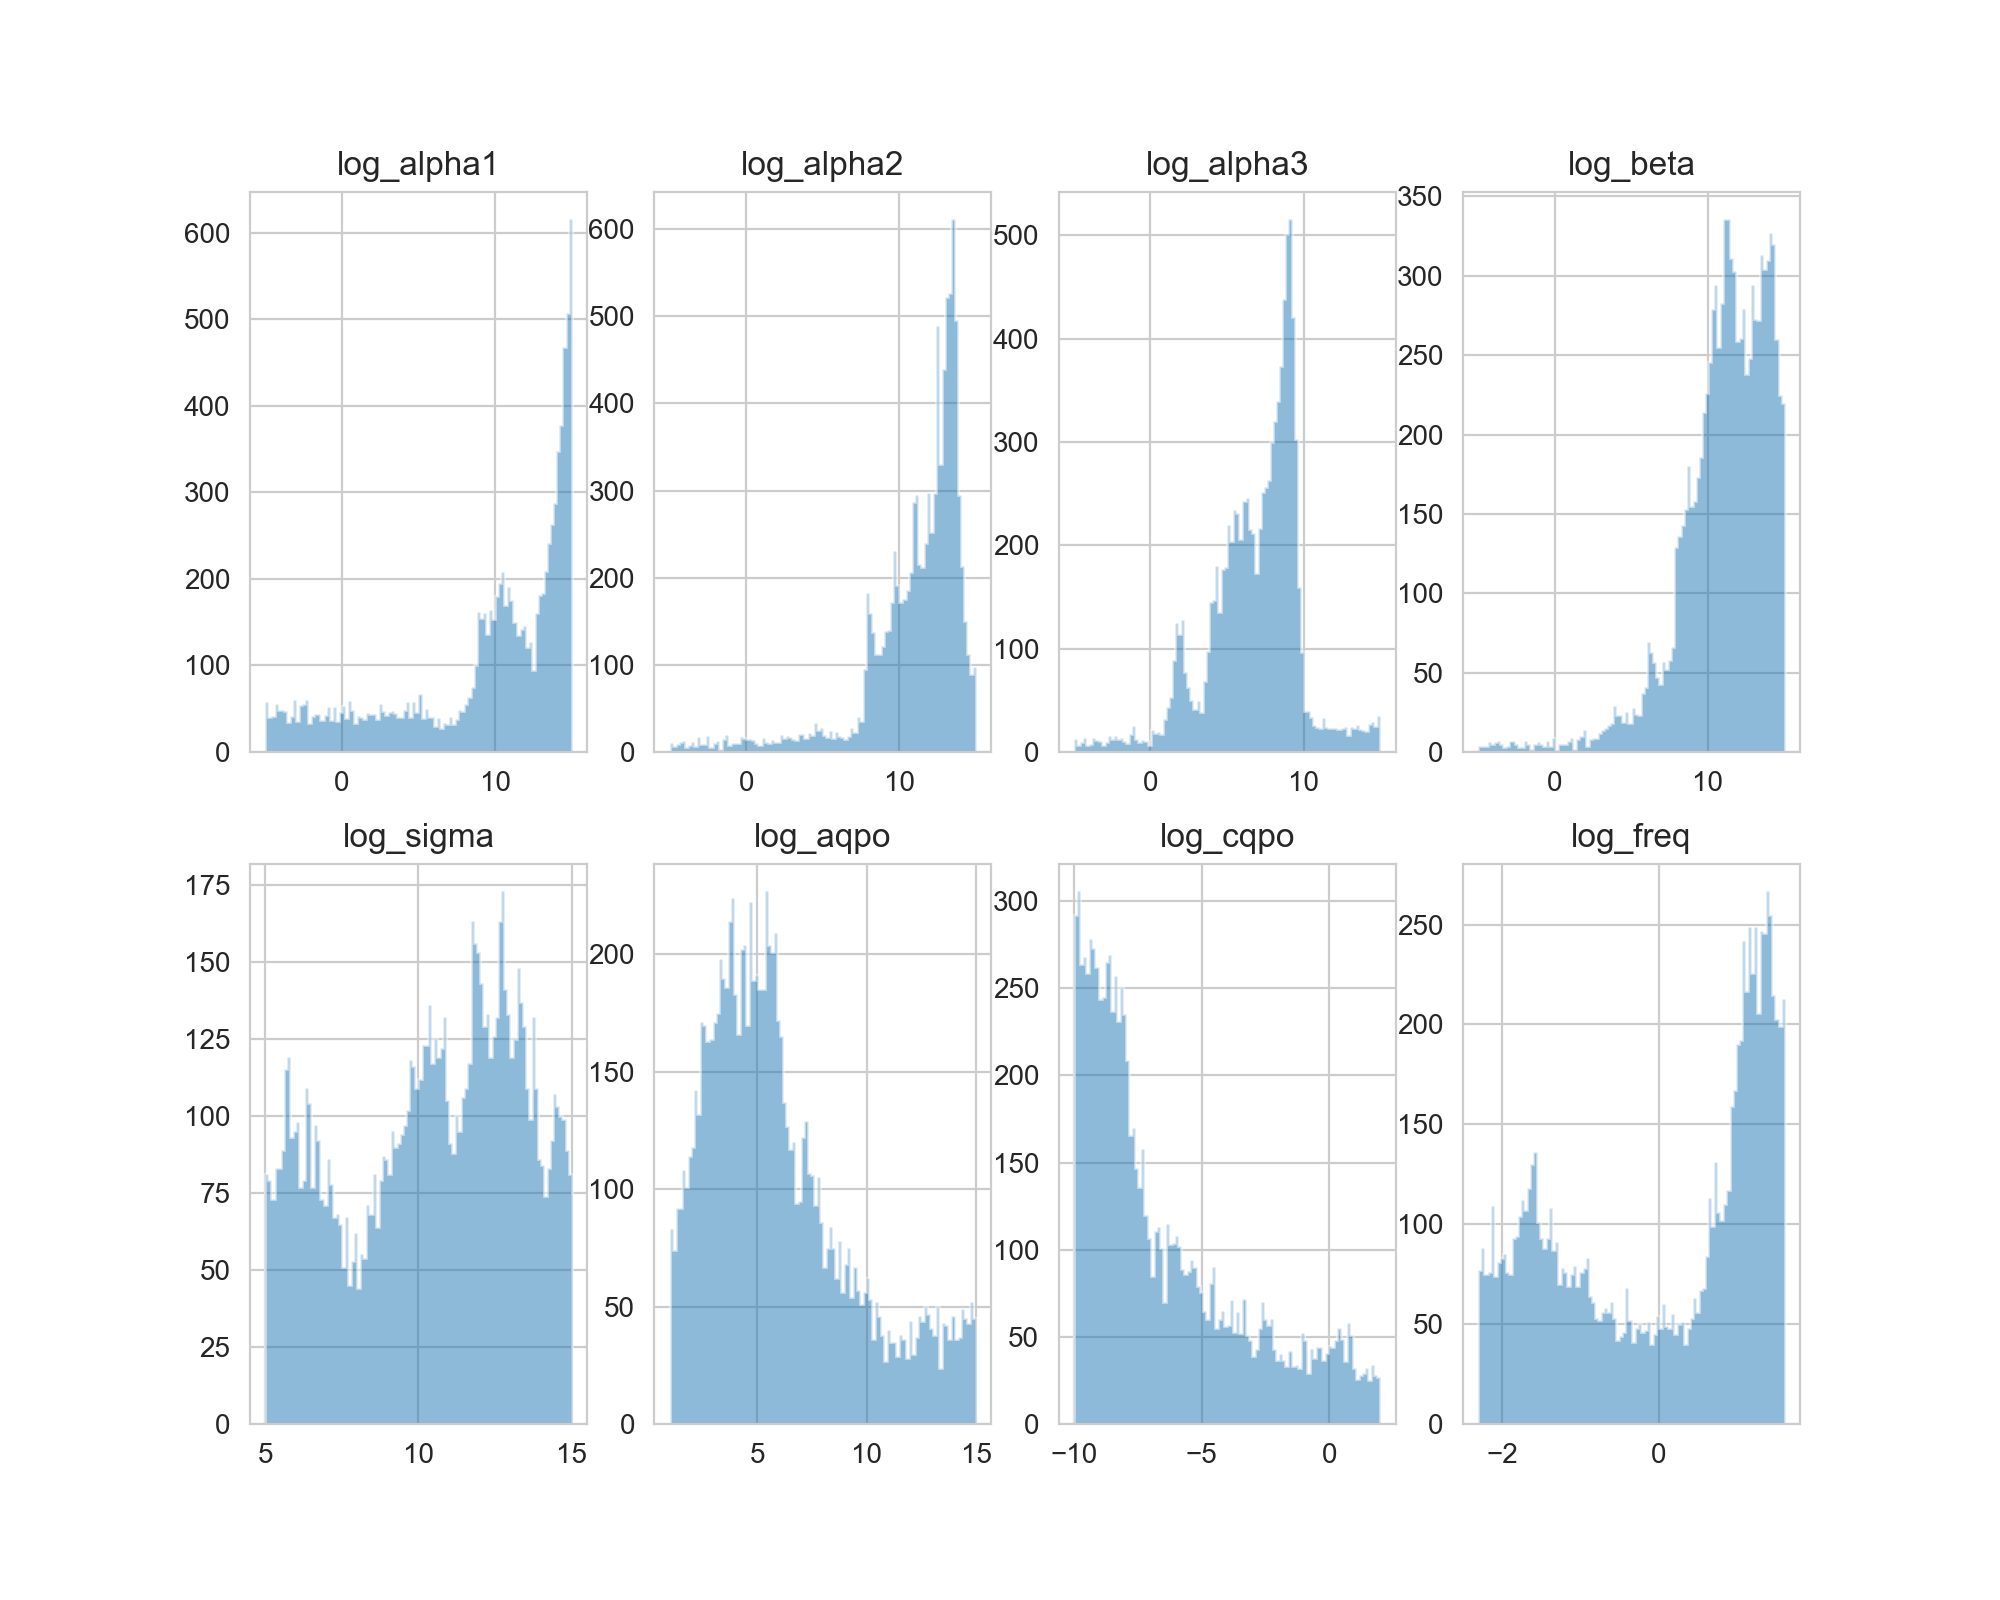

In [371]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_alpha3",
                    "log_beta", "log_sigma", "log_aqpo", 
                    "log_cqpo", "log_freq"]


fig, axes = plt.subplots(2, 4, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples_qpo[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [372]:
def lorentzian(freq, amp, f0, fwhm):
    """
    A Lorentzian function (Cauchy distribution)
    
    Parameters
    ----------
    freq : numpy.ndarray
        An array of frequencies for which to 
        compute the Lorentzian
        
    amp : float
        The amplitude of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    fwhm : float
        The full-width at half-maximum of the 
        Lorentzian
        
    Returns
    -------
    lor : numpy.ndarray
        The values of the Lorentzian for the 
        given parameters and frequency array
    
    """
    num = amp * fwhm**2.
    denom = fwhm**2. + (freq - f0)**2.0
    
    return num/denom   

<IPython.core.display.Javascript object>


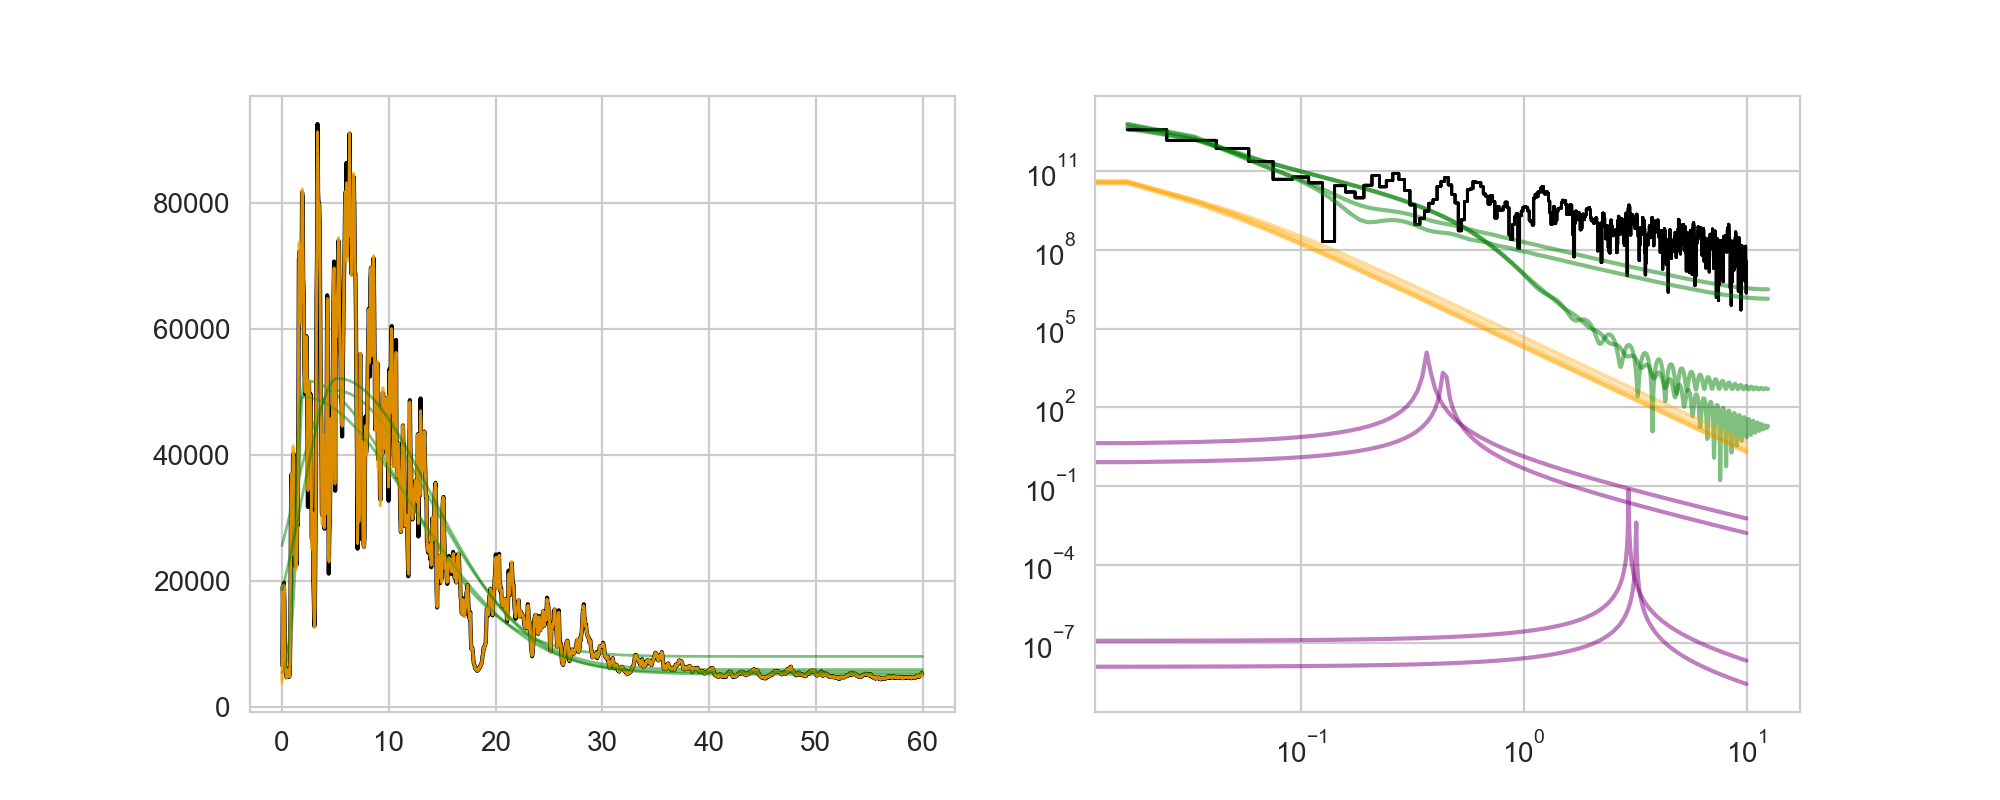

In [373]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time[:npoints], lc.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 4 # number of simulated light curves / PSDs
nsamples = samples_qpo["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc.n, d=lc.dt)
freq = freq[:int(lc.n/2)]
# calculate periodogram for comparison:
ps = Powerspectrum(lc, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples_qpo["log_amp"][idx],
              samples_qpo["t0"][idx],
              samples_qpo["log_sig1"][idx],
              samples_qpo["log_sig2"][idx],
              samples_qpo["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples_qpo["log_alpha1"][idx]),
             jnp.exp(samples_qpo["log_alpha2"][idx]),
             jnp.exp(samples_qpo["log_alpha3"][idx])]
    
    beta_post = jnp.exp(samples_qpo["log_beta"][idx])
    sigma_post = jnp.exp(samples_qpo["log_sigma"][idx])

    
    kernel_carma = CARMA.init(alpha=alpha_post, 
                        beta=beta_post, 
                        sigma=sigma_post)
    
    
    aqpo_post = jnp.exp(samples_qpo["log_aqpo"][idx])
    cqpo_post = jnp.exp(samples_qpo["log_cqpo"][idx])
    freq_post = jnp.exp(samples_qpo['log_freq'][idx])
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=aqpo_post,
            b=0.0,
            c=cqpo_post,
            d=2 * jnp.pi * freq_post
        )
    
    # add kernels together
    kernel_post = kernel_carma + kernel_qpo
    
    gp = GaussianProcess(kernel_post, lc.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    # PSD of the CARMA process
    psd_carma = power_spectrum(freq, sigma_post, alpha_post, ma_coefs=[beta_post])
    psd_lor = lorentzian(freq, aqpo_post, freq_post, cqpo_post)
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps.freq, ps.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd_carma, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)
    ax2.loglog(freq, psd_lor, color="purple", alpha=0.5)


1200